In [1]:
from Constants import ROOT_DIR, \
    H5_DIR_FULLYCONNECTED_MULTIPLE_RELU,\
    H5_DIR_FULLYCONNECTED_MULTIPLE_ELU,\
    H5_DIR_COVNET_MULTIPLE_RELU,\
    H5_DIR_COVNET_MULTIPLE_ELU,\
    H5_DIR_COVNET_JUMP_SIGMA,\
    H5_DIR_COVNET_JUMP_MU,\
    H5_DIR_COVNET_LAMBDA,\
    H5_DIR_ENSEMBLING

In [11]:
import numpy as np
import math
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pylab

from scipy import stats
from numpy import random as nrand

%matplotlib inline

# Optional:
import seaborn as sns

In [3]:
import tensorflow as tf
import keras
from keras.models import Model, Sequential, model_from_json, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, LSTM, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D, Conv2D, Input
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import backend as K
from keras.layers.core import Reshape

Using TensorFlow backend.


In [4]:
from Merton_Jump_Diffusion_SDE_Utilities import \
    ModelParameters, \
    random_model_params, \
    geometric_brownian_motion_jump_diffusion_log_returns

In [5]:
def test_set_model_params():
    return ModelParameters(
        all_time=2000,
        all_delta=0.00396825396,
        all_sigma = 0.1,
        gbm_mu = 0.05,
        jumps_sigma=0.07,
        jumps_mu=0.05,
        jumps_lamda=0.02)

def standard_convolutional_test_set(sample_size = 1000, dim = (40, 50)):
    test_set = []
    for i in range(sample_size):
        if (i%100 == 0):
            print(i)
        test_set.append(geometric_brownian_motion_jump_diffusion_log_returns(test_set_model_params()))

    test_set_pred = np.reshape(np.array(test_set), (sample_size, dim[0], dim[1], 1))
    return test_set_pred

def convolutional_batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_data = np.reshape(np.array(RETURNS_), (paramset_size*paths_p_paramset, 40, 50, 1))
        sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
        mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
        jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
        jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
        lambdas = np.array([[mp.lamda] for mp in PARAMS_])
        
        yield train_data, [sigmas, mus, jump_sigmas, jump_mus, lambdas]

def standard_fullyconnected_test_set(sample_size = 1000):
    test_set = []
    for i in range(sample_size):
        if (i%100 == 0):
            print(i)
        test_set.append(geometric_brownian_motion_jump_diffusion_log_returns(test_set_model_params()))

    train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in test_set]
    train_statistics = np.array([np.append(train_moments[i], 
                                  sm.tsa.stattools.acf(test_set[i])) 
                        for i in range(len(test_set))])
    return train_statistics

def fullyconnected_batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in RETURNS_]

        train_statistics = np.array([np.append(train_moments[i], 
                              sm.tsa.stattools.acf(RETURNS_[i])) 
                    for i in range(len(RETURNS_))])
        
        sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
        mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
        jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
        jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
        lambdas = np.array([[mp.lamda] for mp in PARAMS_])
        
        yield train_statistics, [sigmas, mus, jump_sigmas, jump_mus, lambdas]

In [7]:
def predictions_hist(predictions, true_value, plot_title = "model", param_name = "param", min_edge = None, max_edge = None, y_lim = (None, None), bin_size = 0.0025, img_subdir = "/Images/", save_to_file = True):
    
    if min_edge == None:
        min_edge = np.min(predictions)
    
    if max_edge == None:
        max_edge = np.max(predictions)
    
    bin_size = (max_edge-min_edge)/75
    N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
    bin_list = np.linspace(min_edge, max_edge, Nplus1)

    fig, ax = pylab.subplots()
    pylab.hist(predictions, bins=bin_list, animated = True)
    #pylab.title(plot_title);
    pylab.axvline(x = true_value, c='k')
    pylab.xlim(min_edge, max_edge)
    
    if y_lim != (None, None):
        pylab.ylim(y_lim[0], y_lim[1])
        
    fig.set_dpi(120)
    if save_to_file:
        fig.savefig(ROOT_DIR + img_subdir + plot_title + "_" + param_name + ".png")
    return fig

### Convolutional Architecture: Multiple Output

In [6]:
histories_elu = np.load("covnet_histories_elu.npy").tolist()
covnet_mo_elu_predictions = np.load("covnet_mo_elu_predictions.npy").tolist()

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


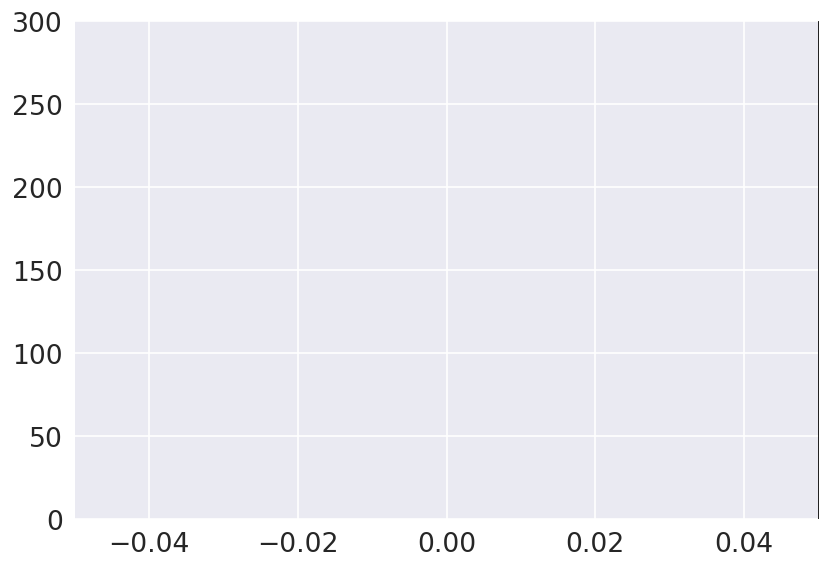

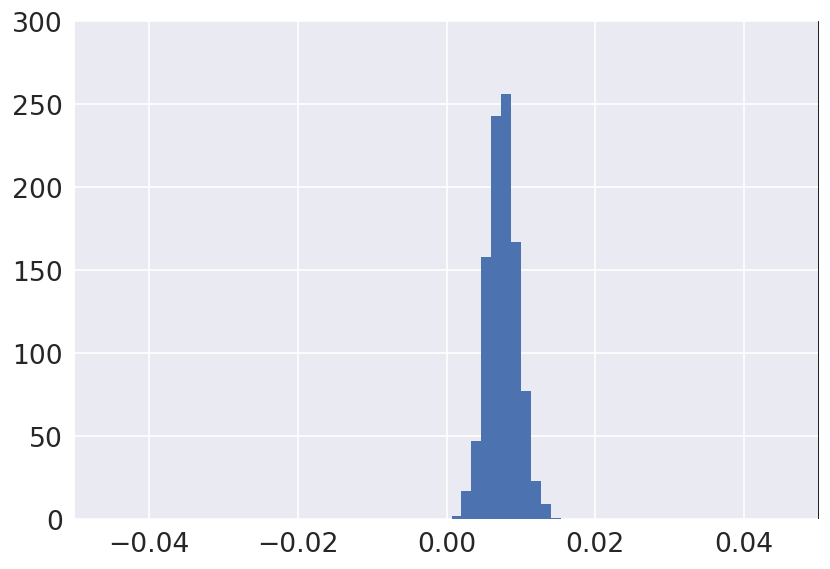

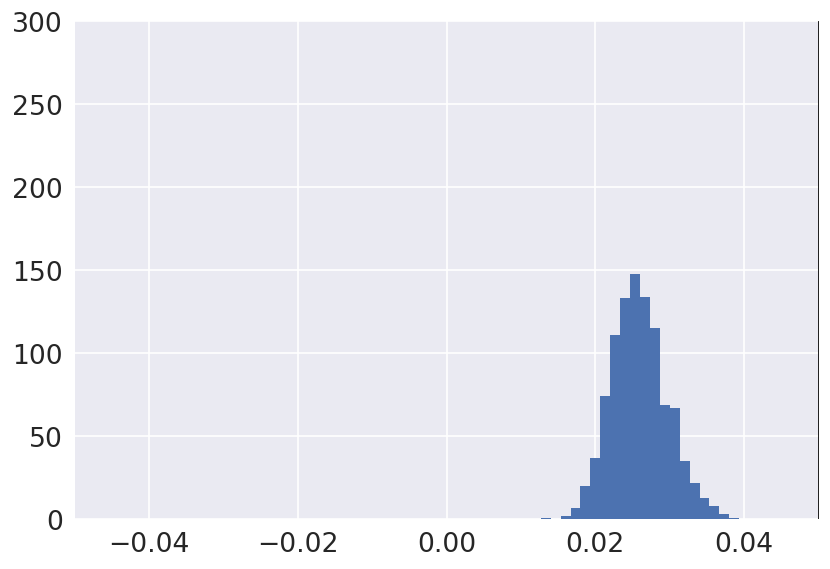

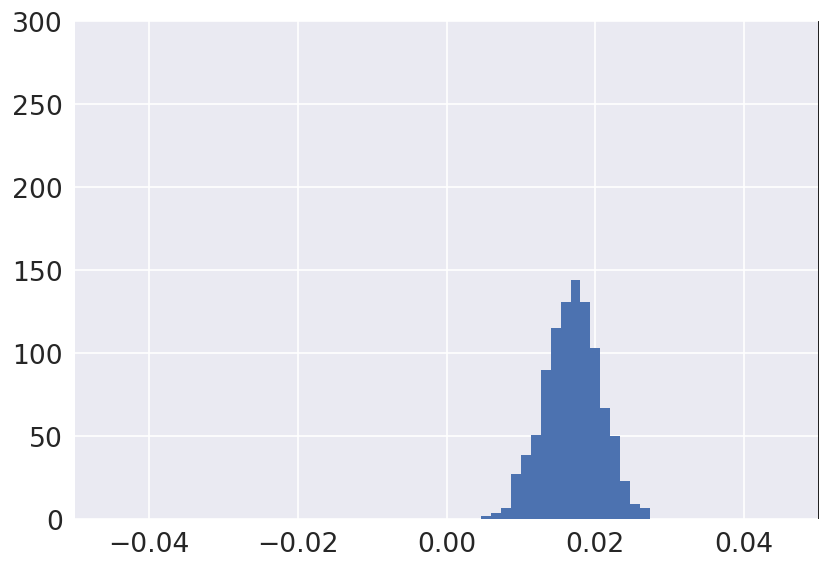

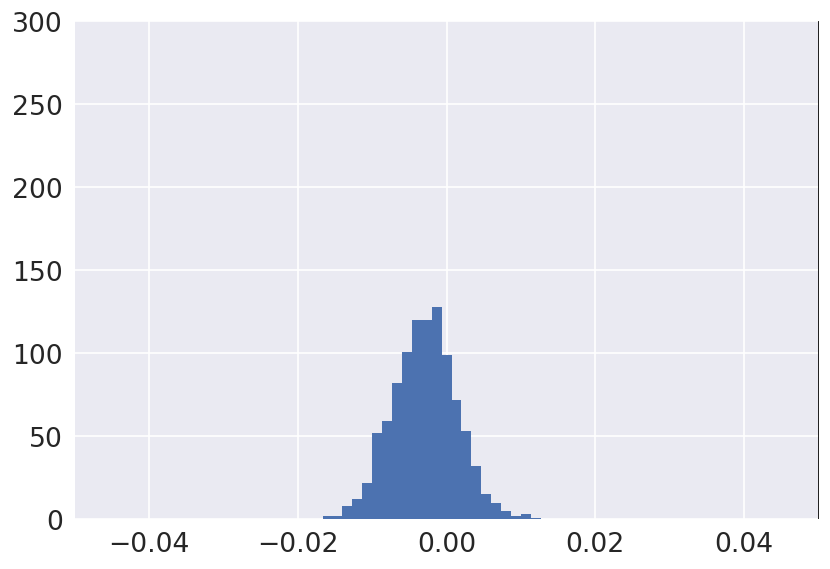

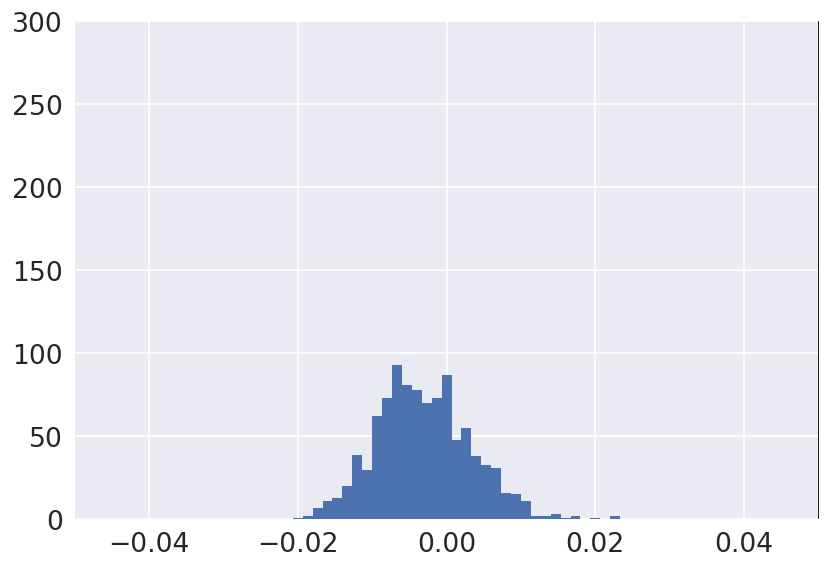

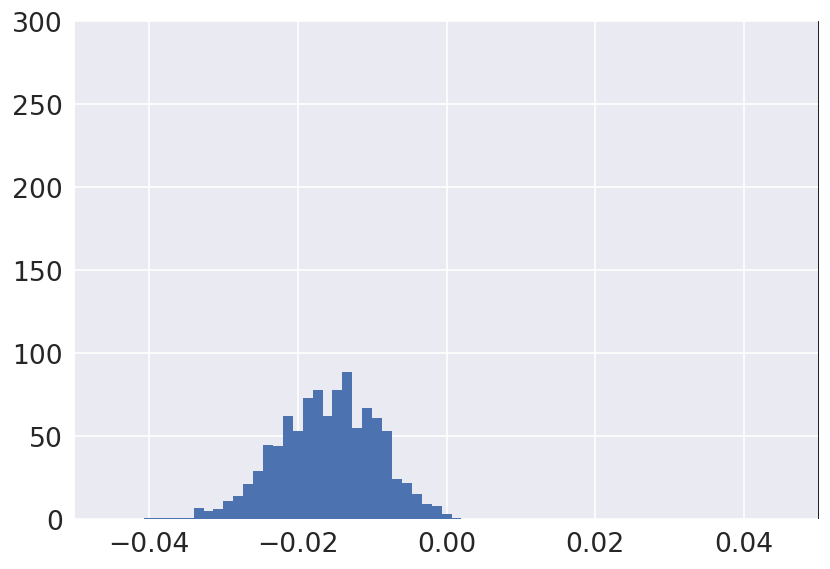

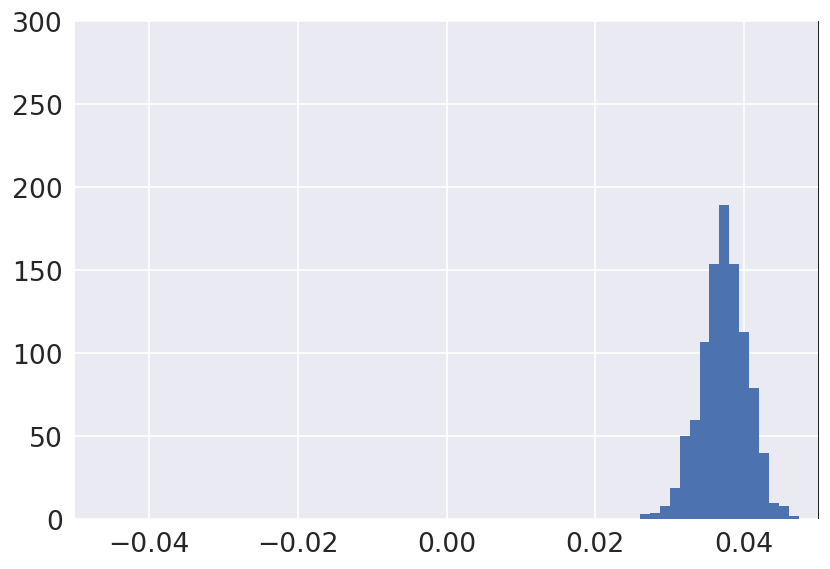

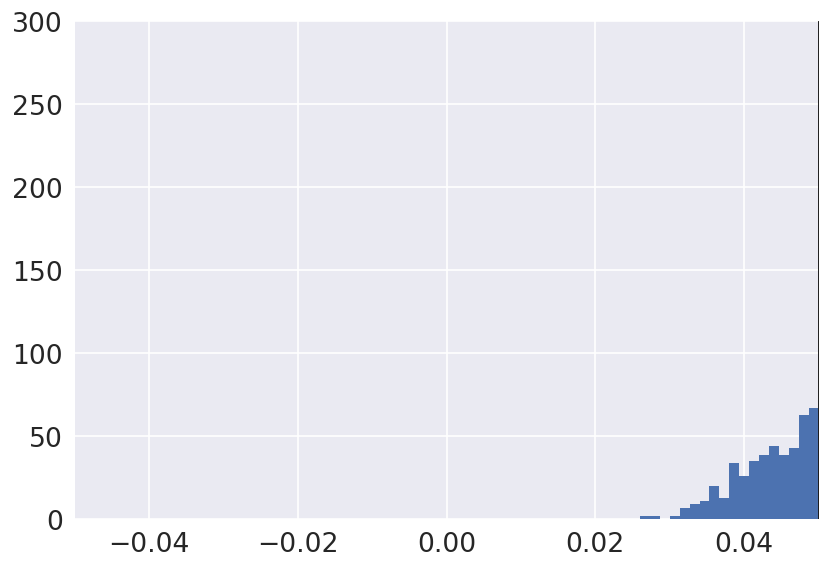

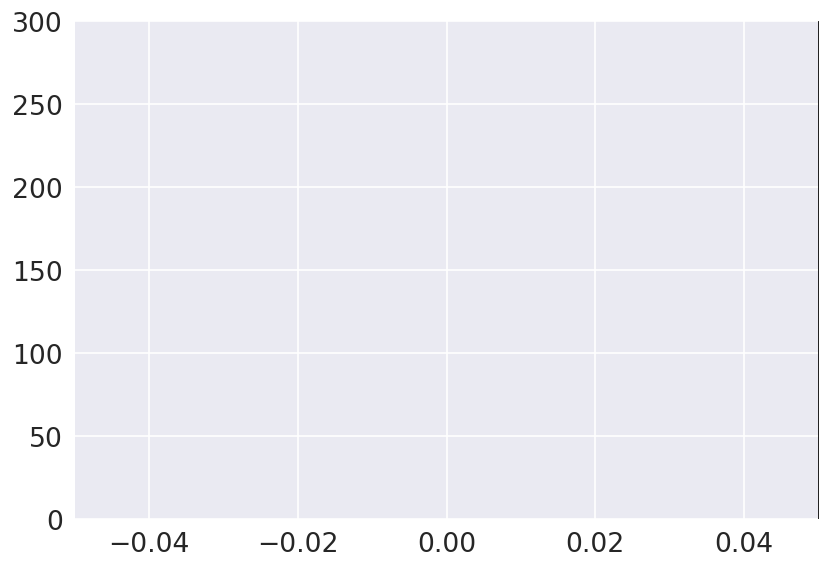

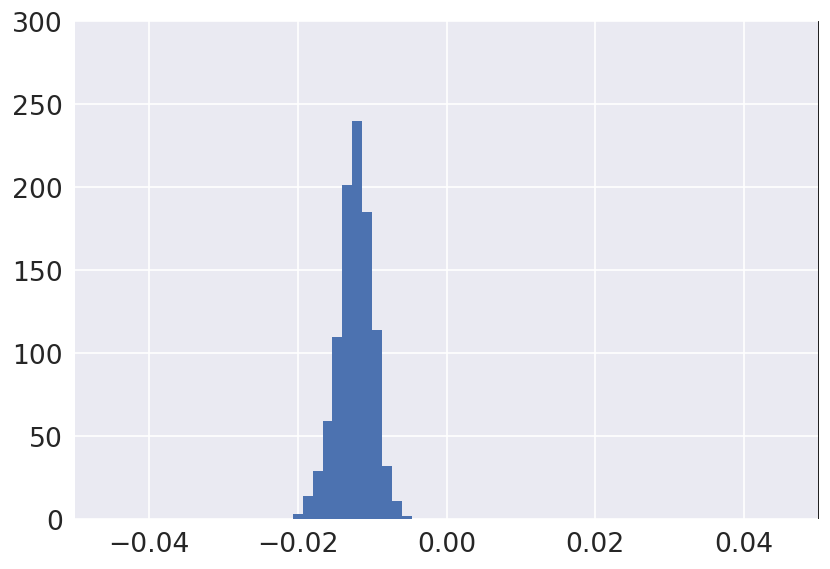

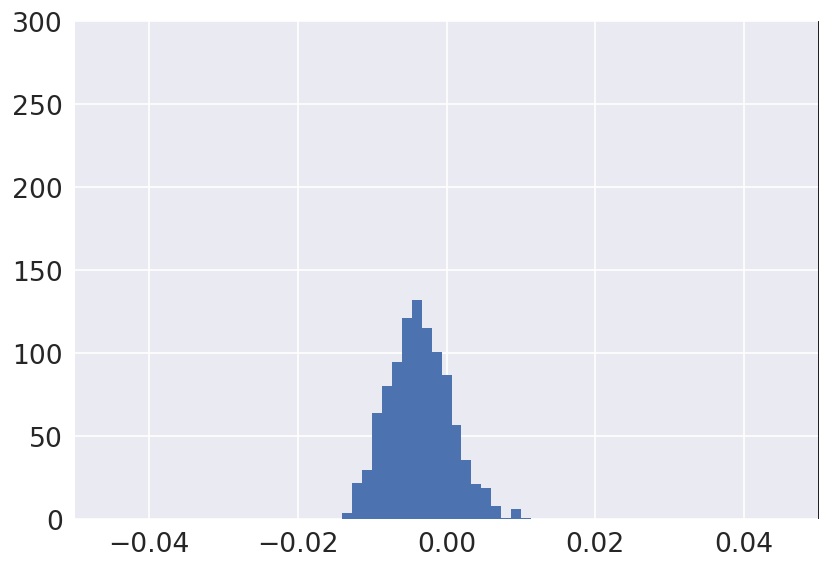

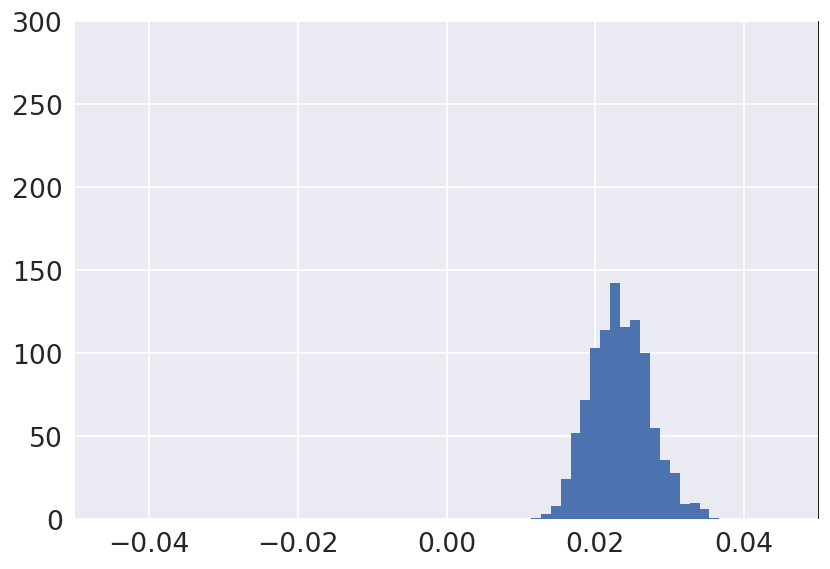

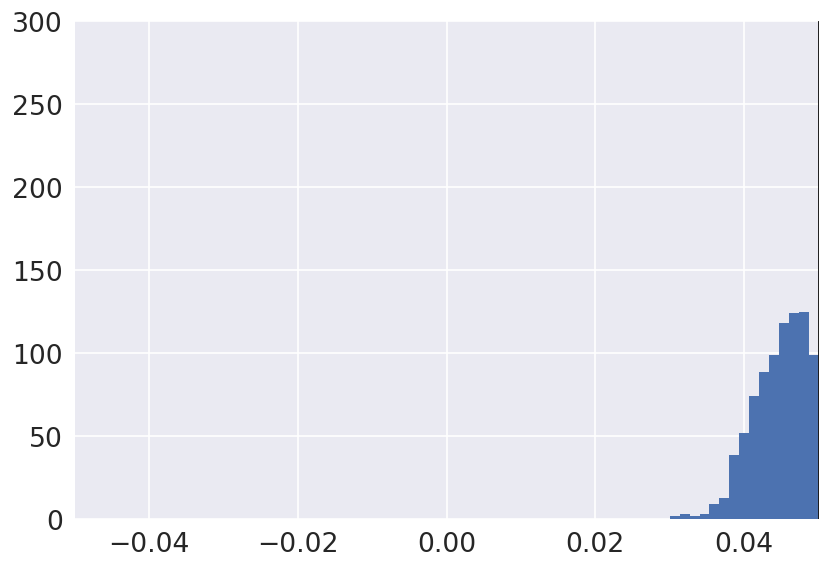

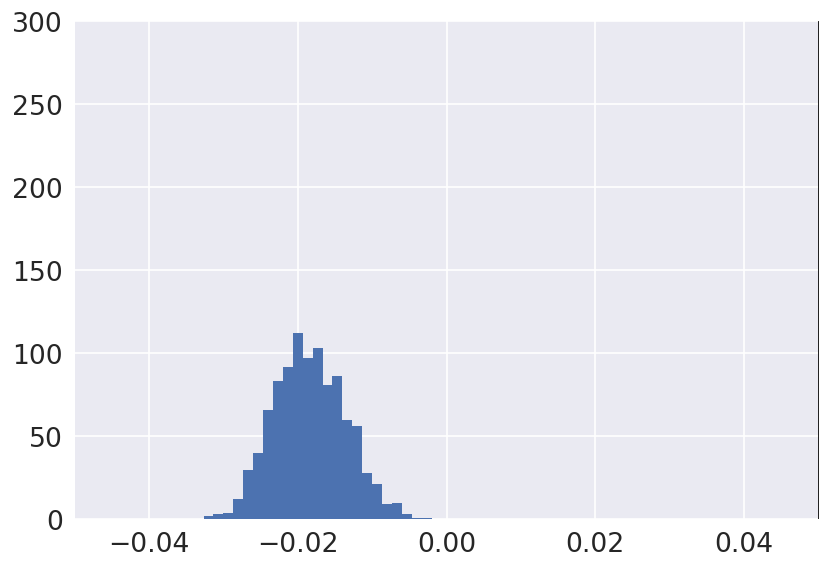

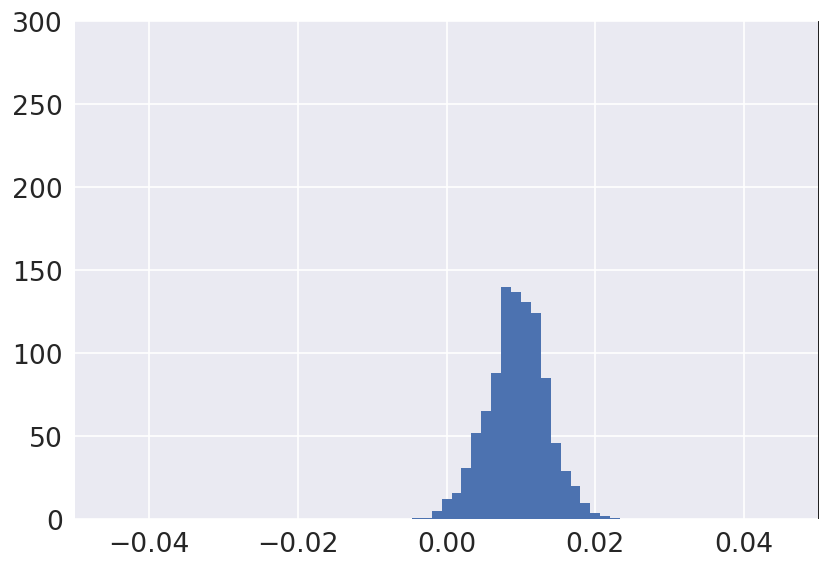

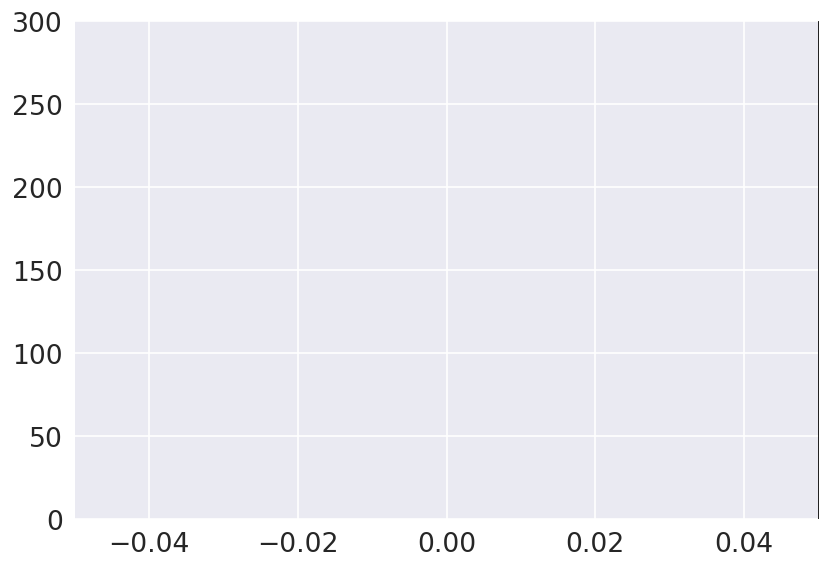

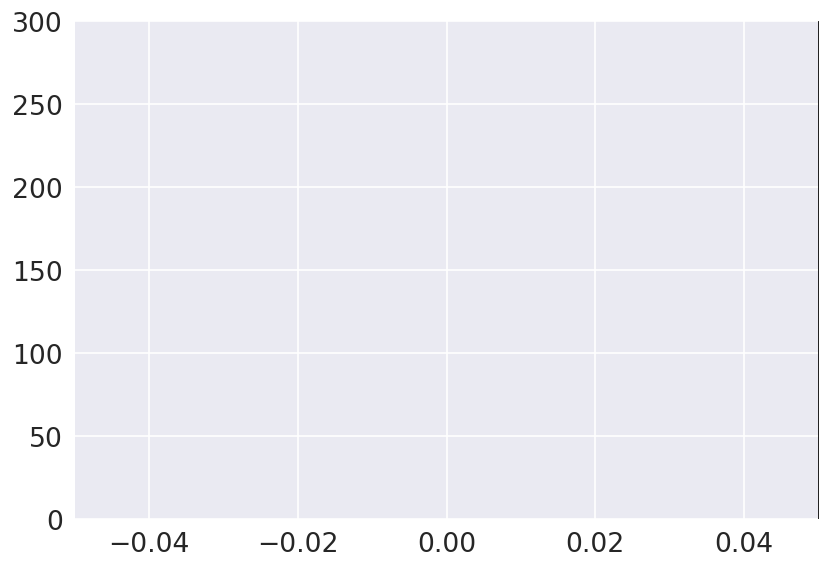

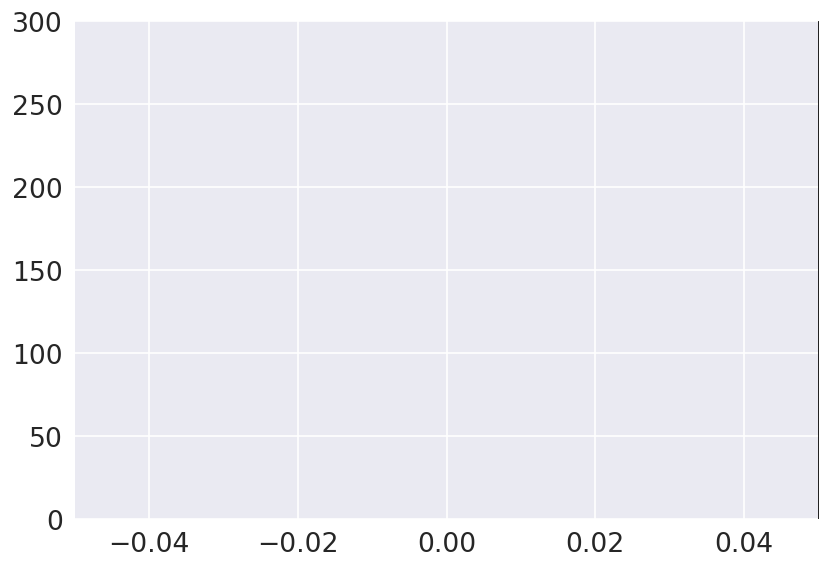

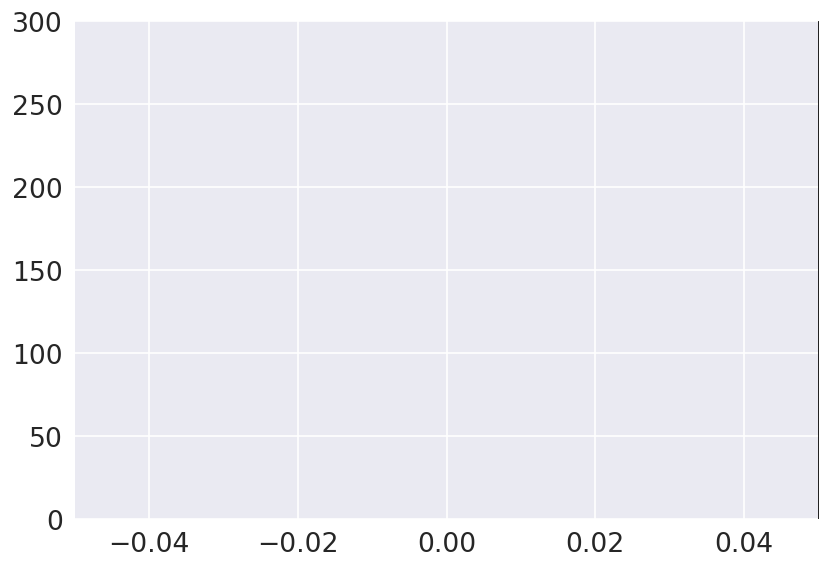

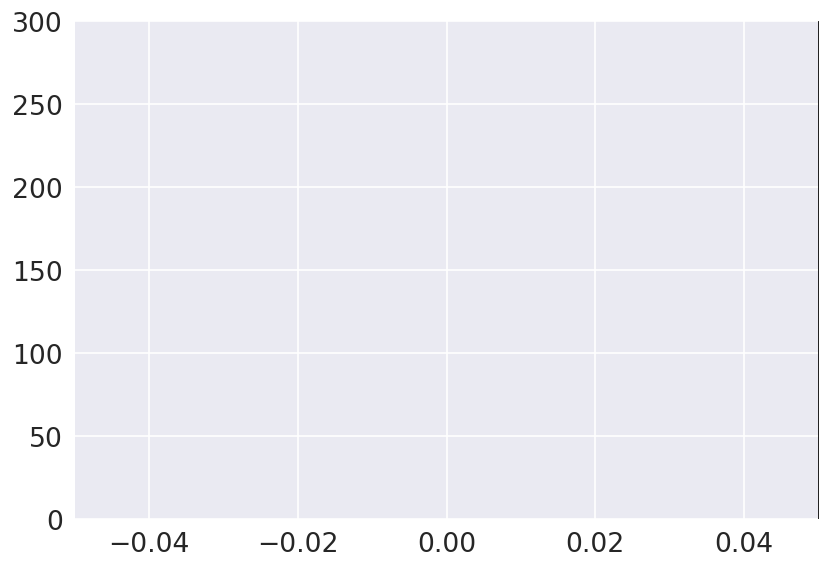

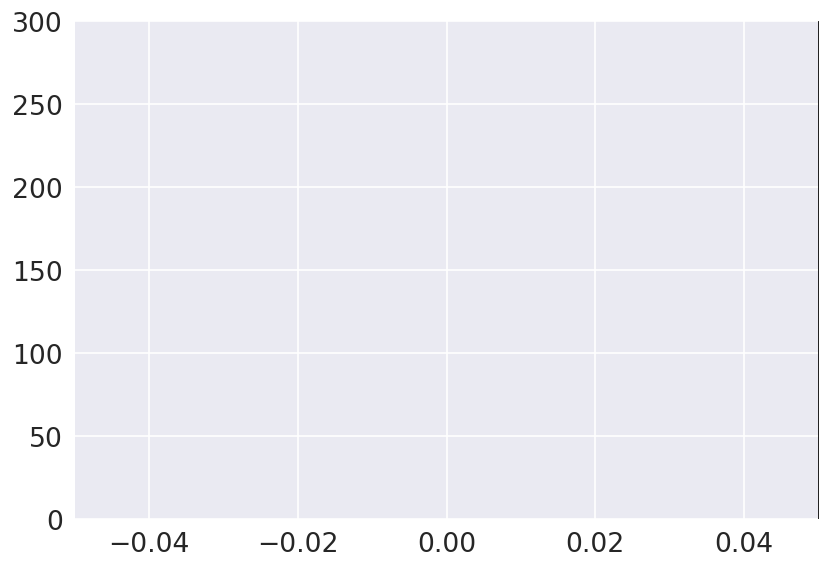

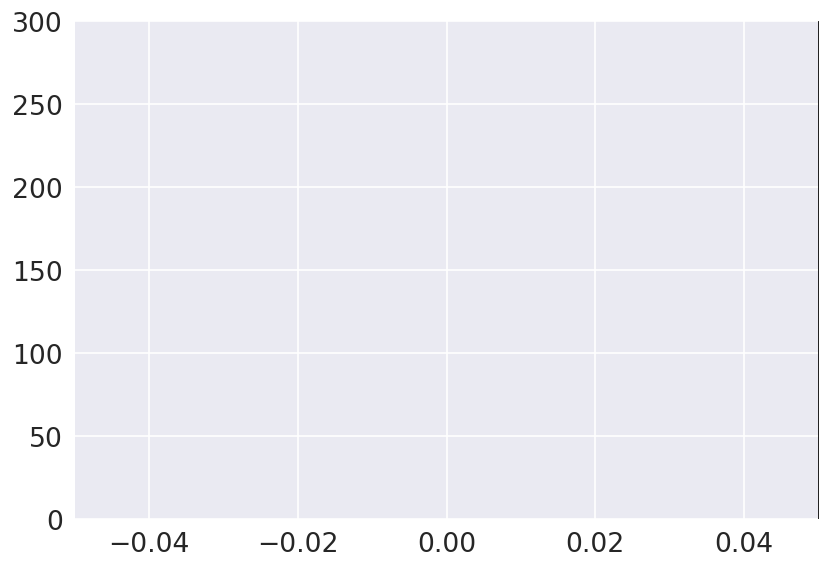

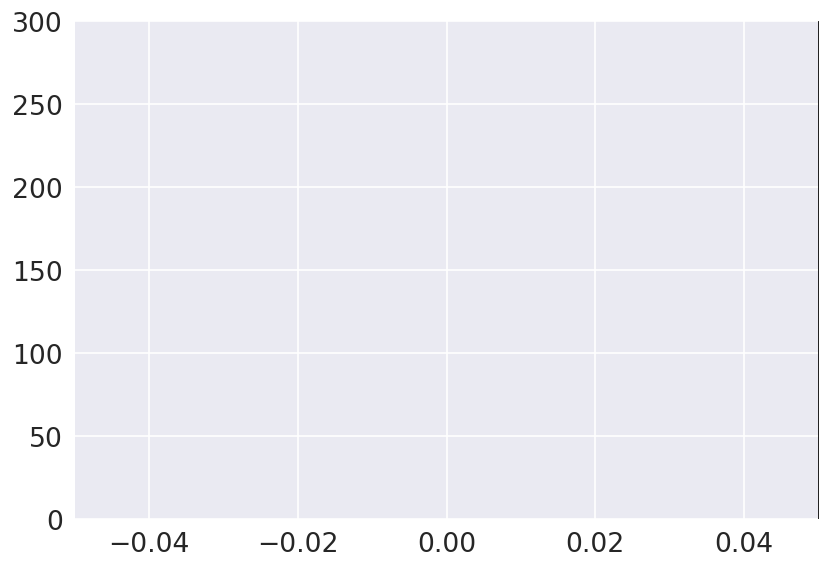

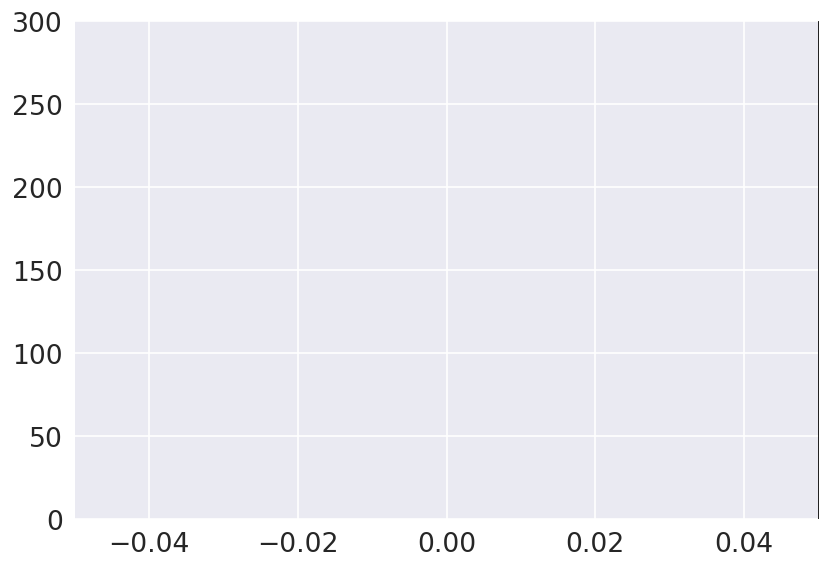

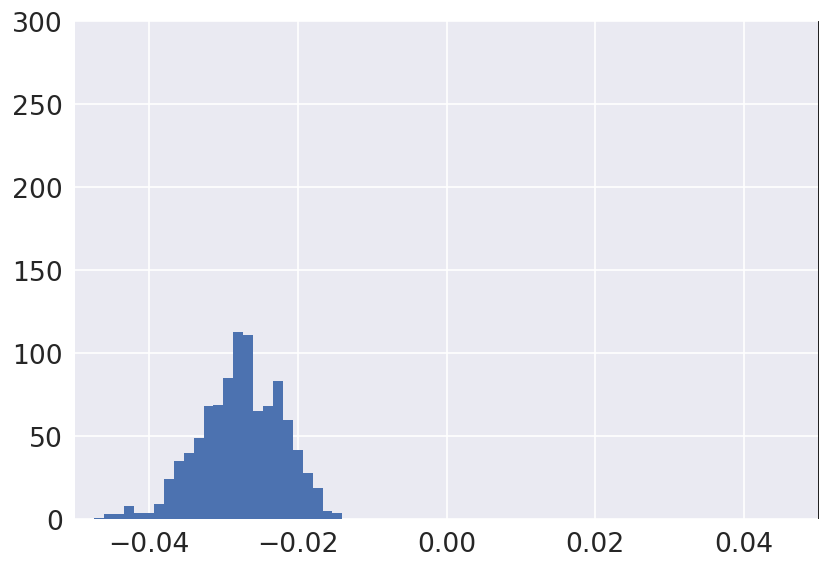

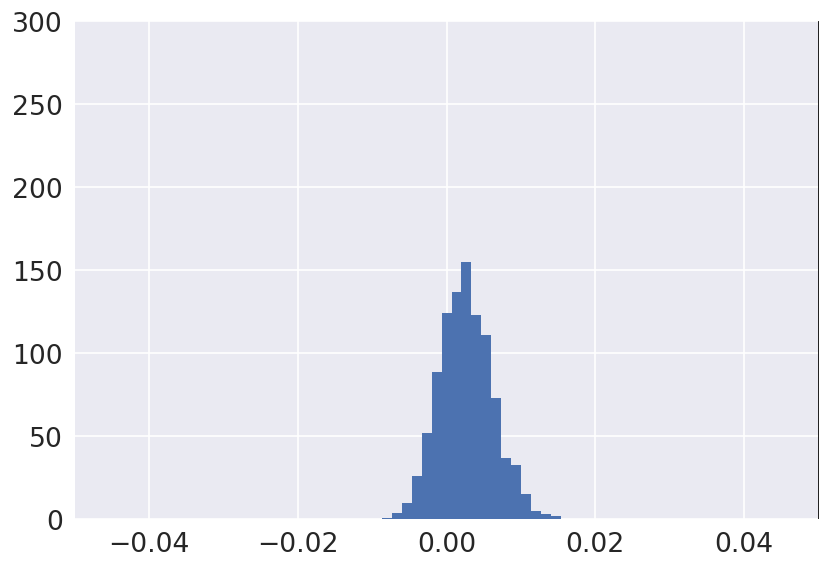

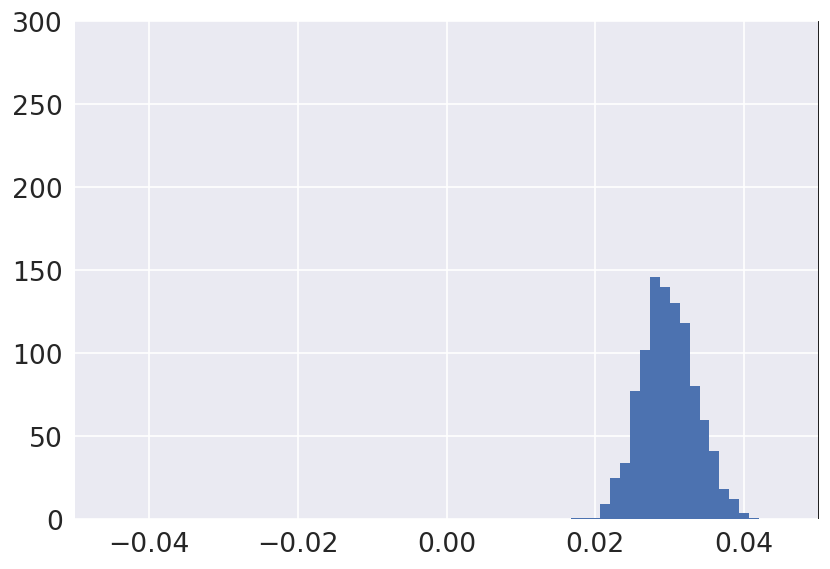

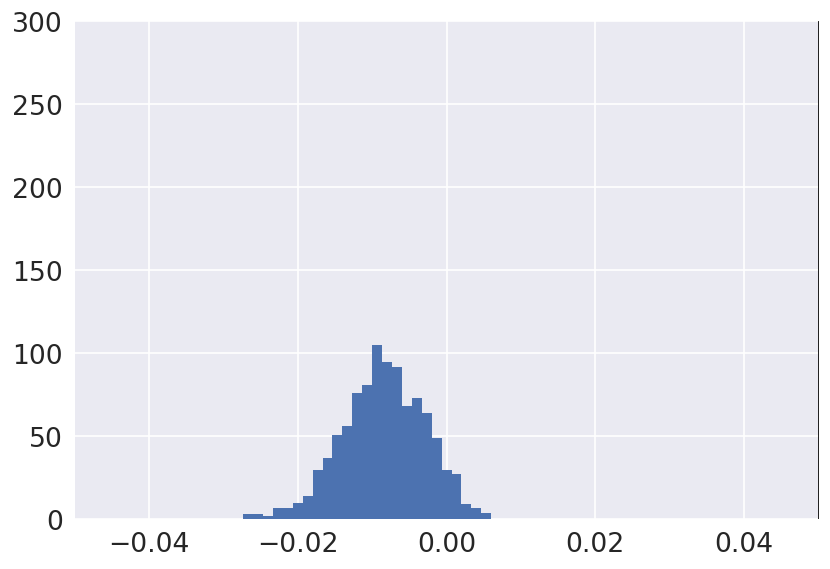

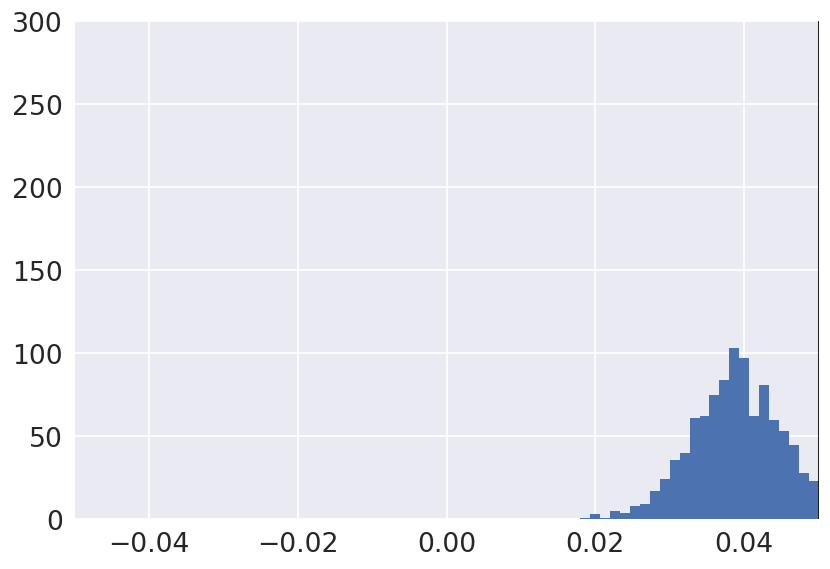

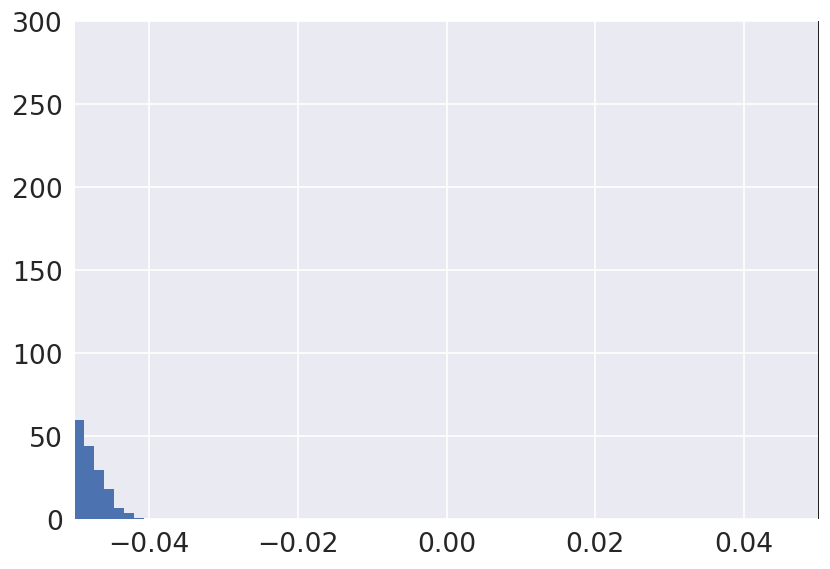

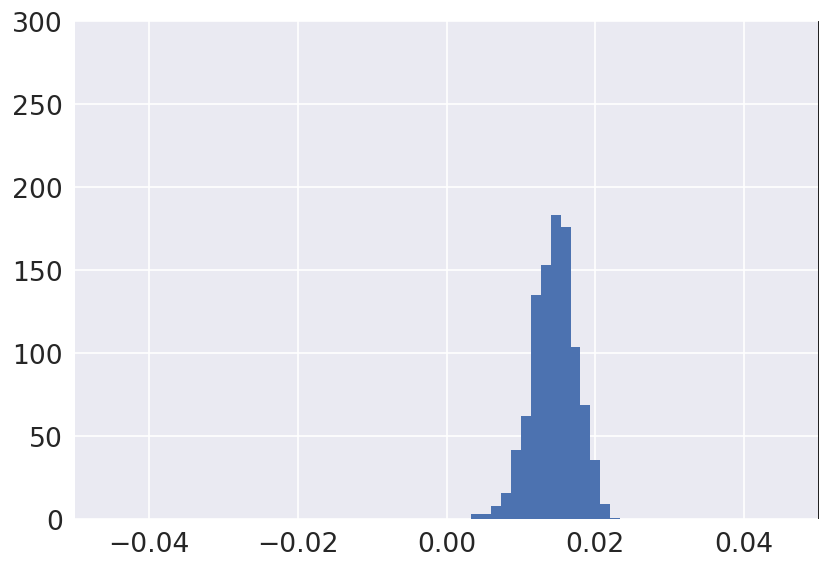

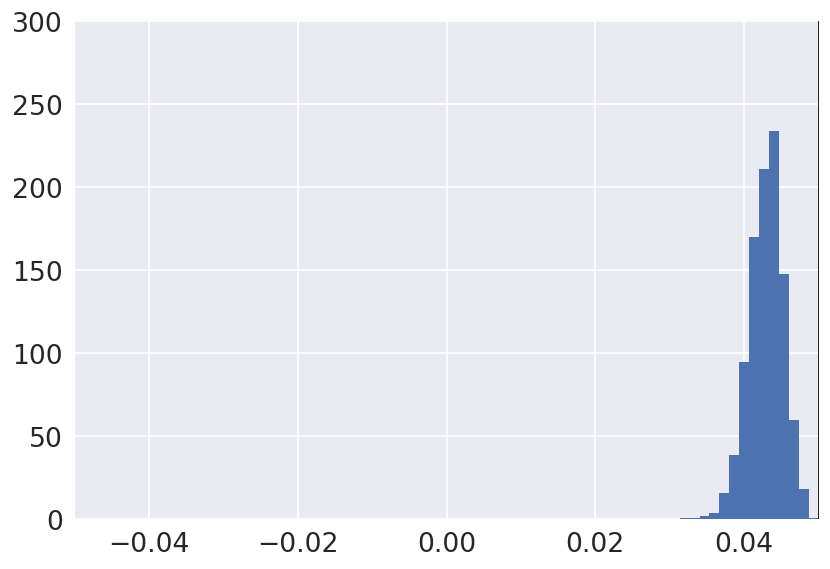

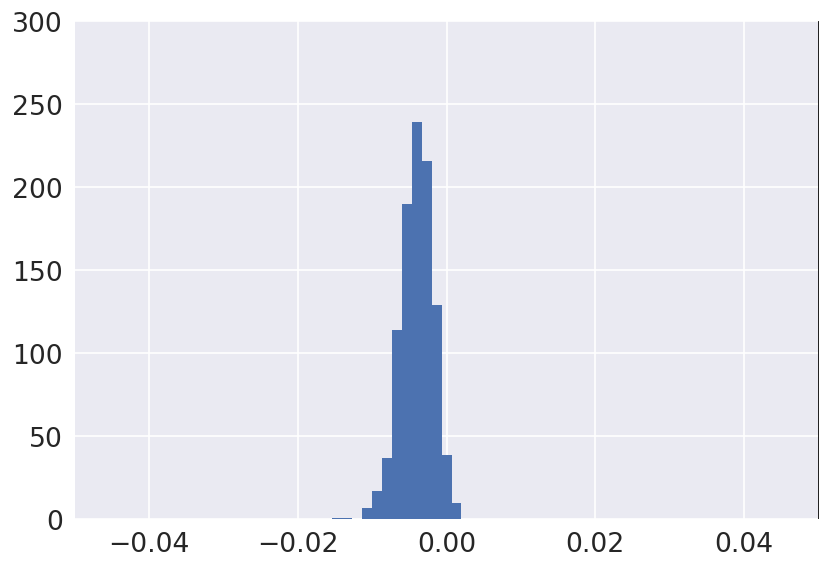

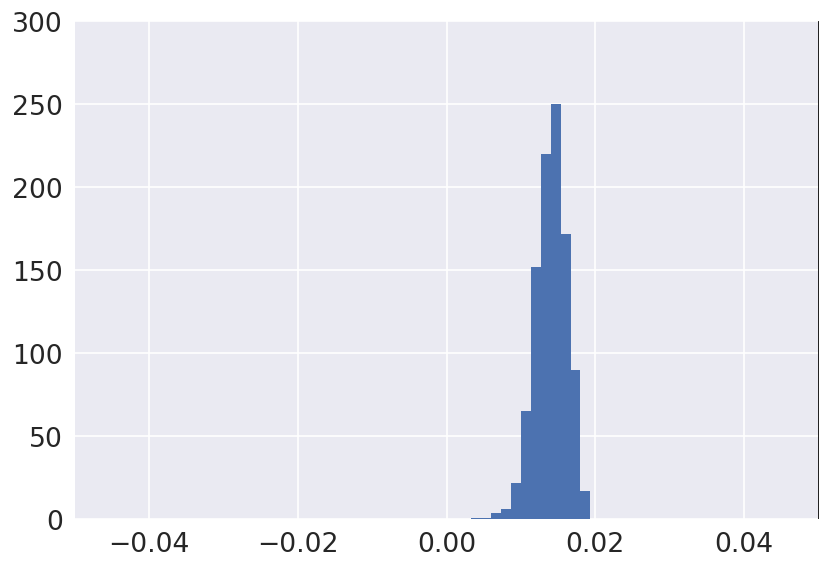

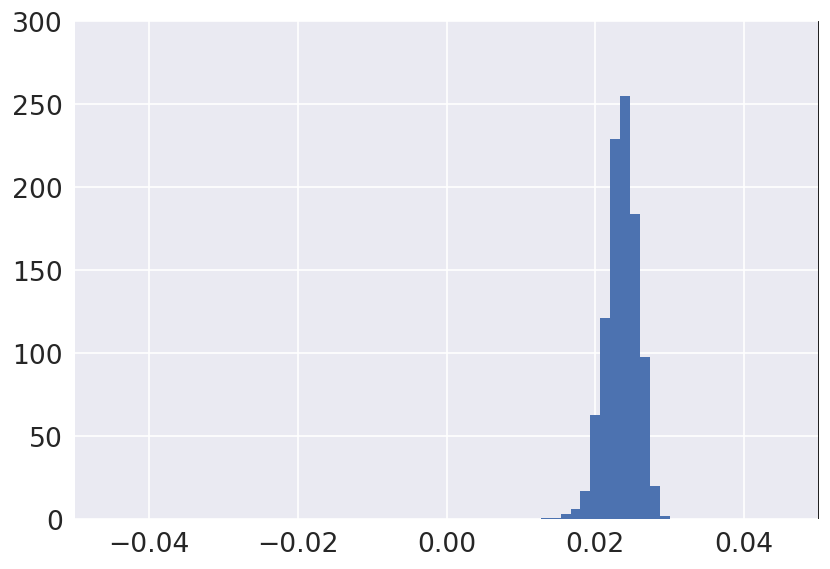

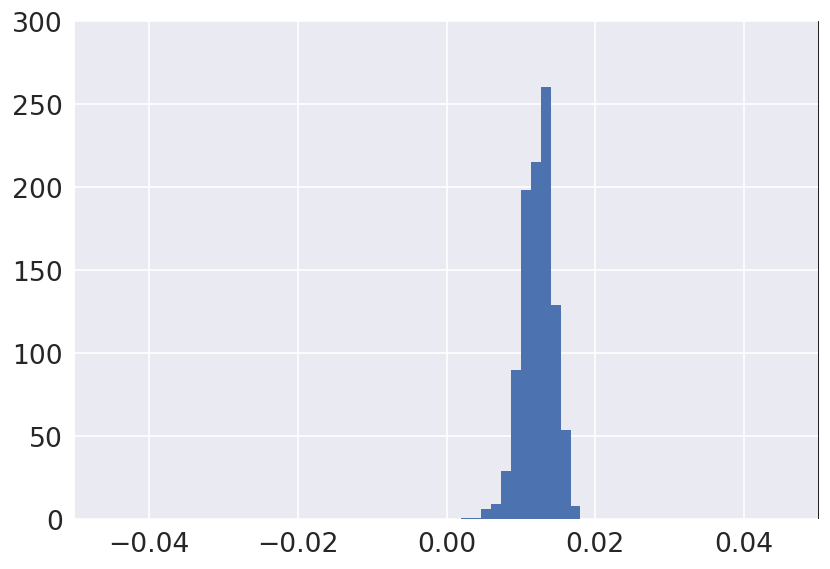

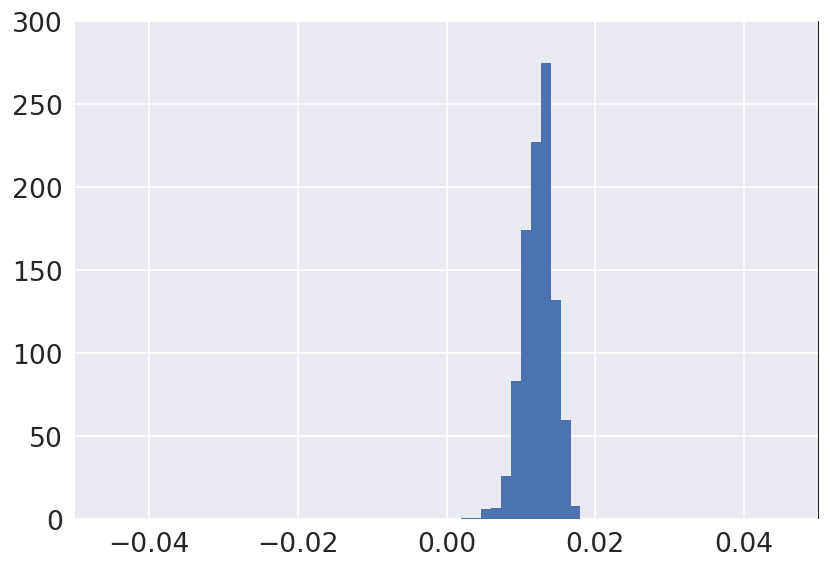

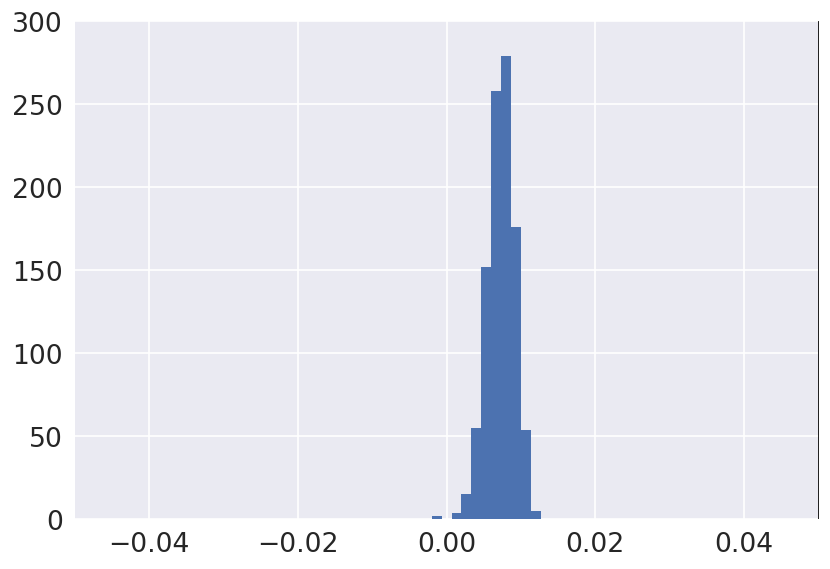

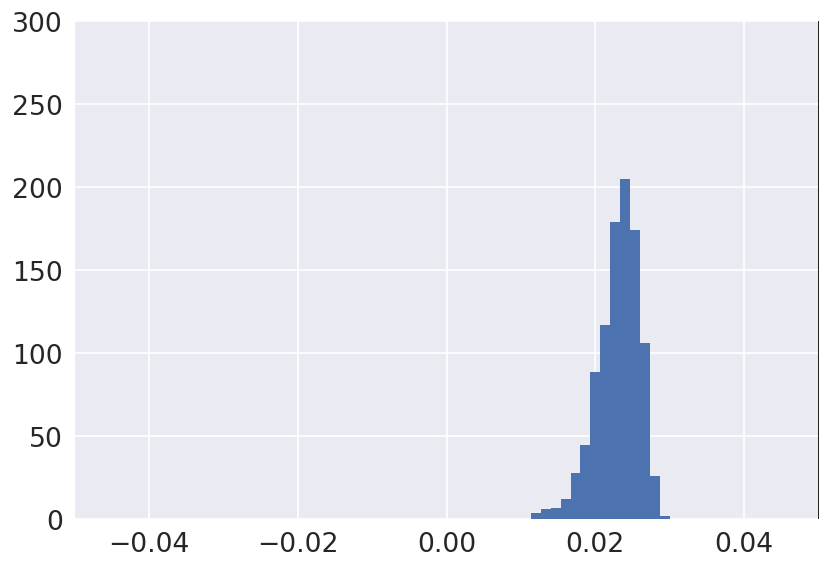

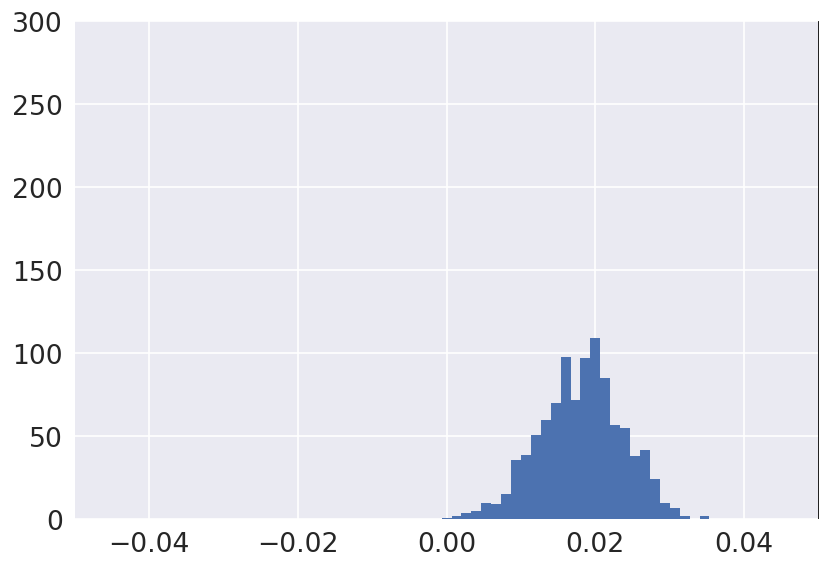

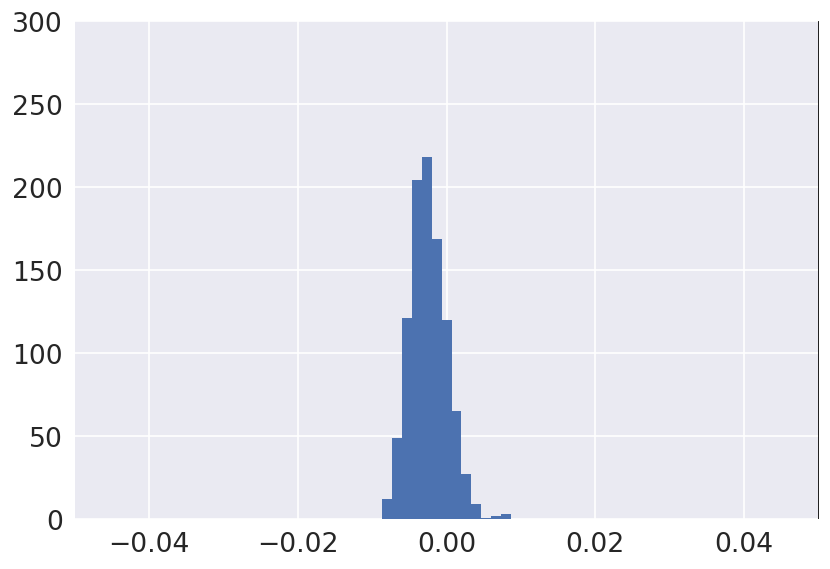

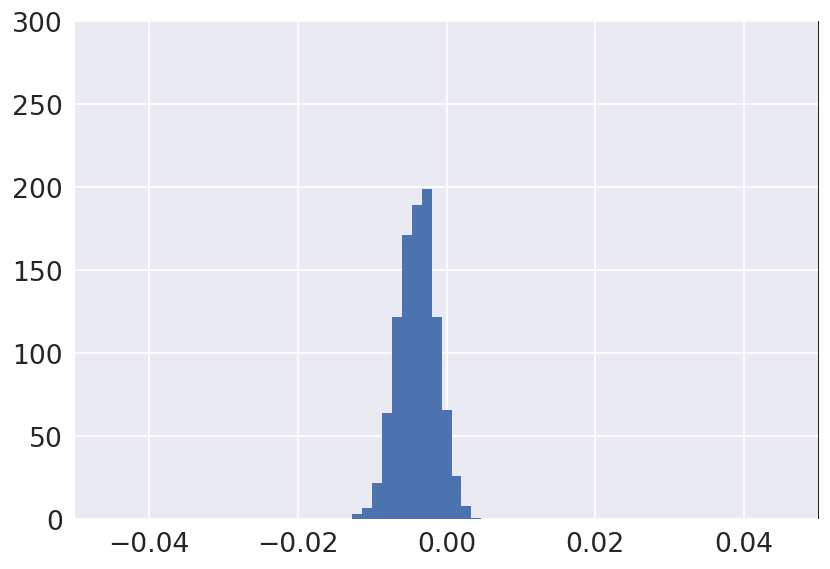

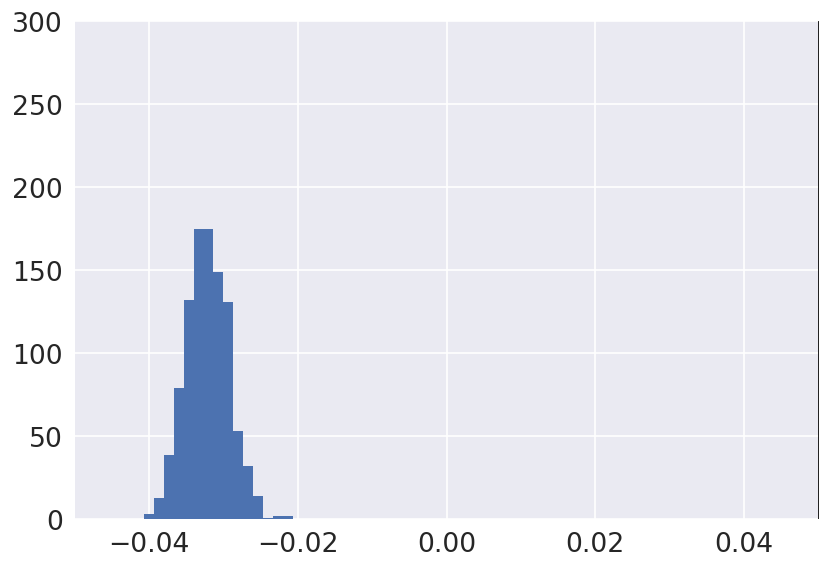

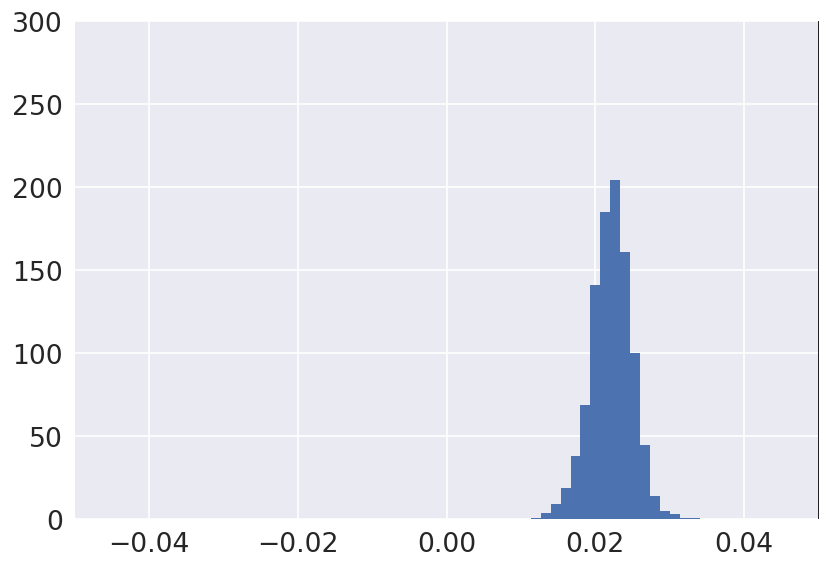

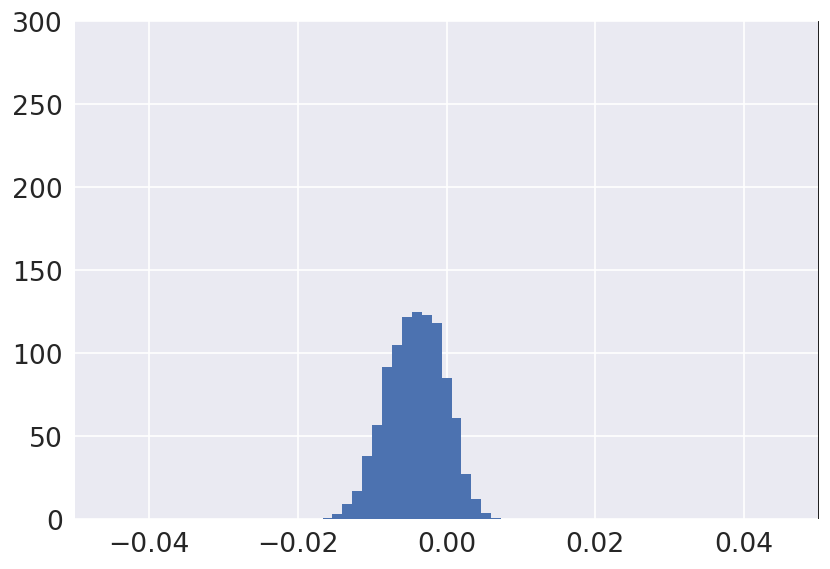

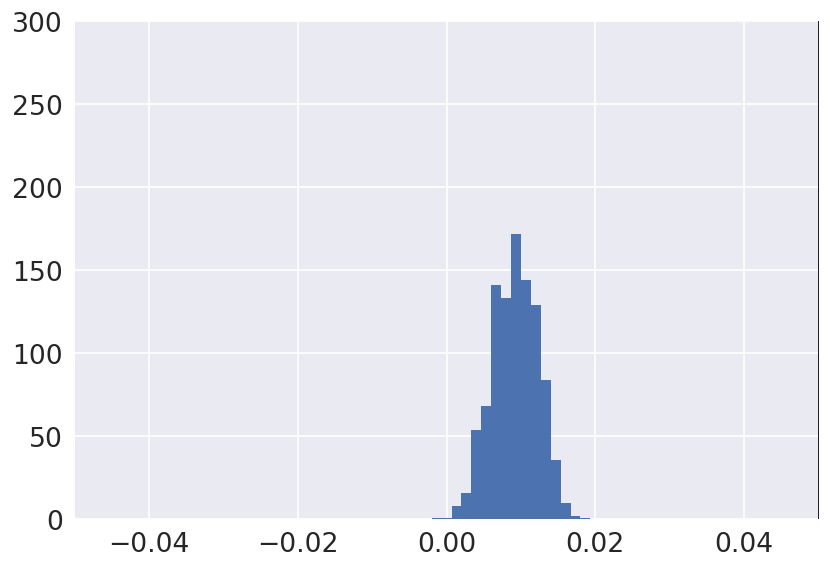

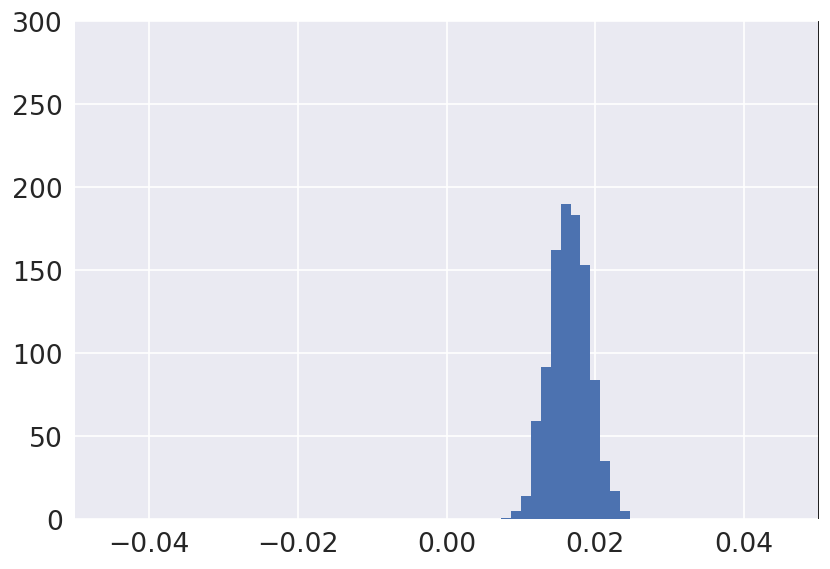

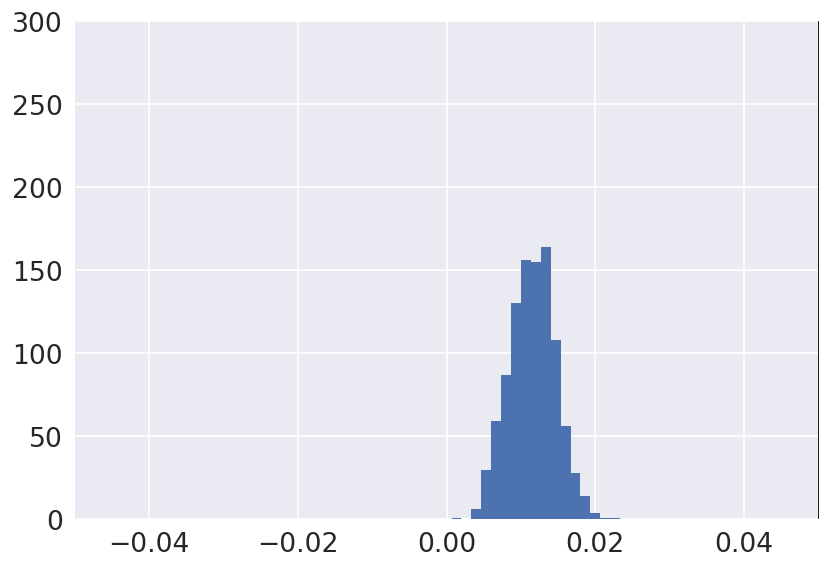

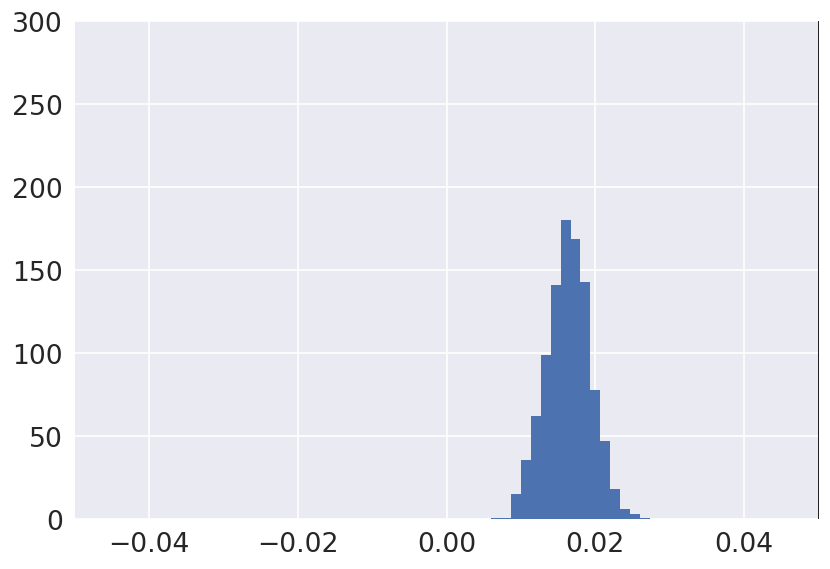

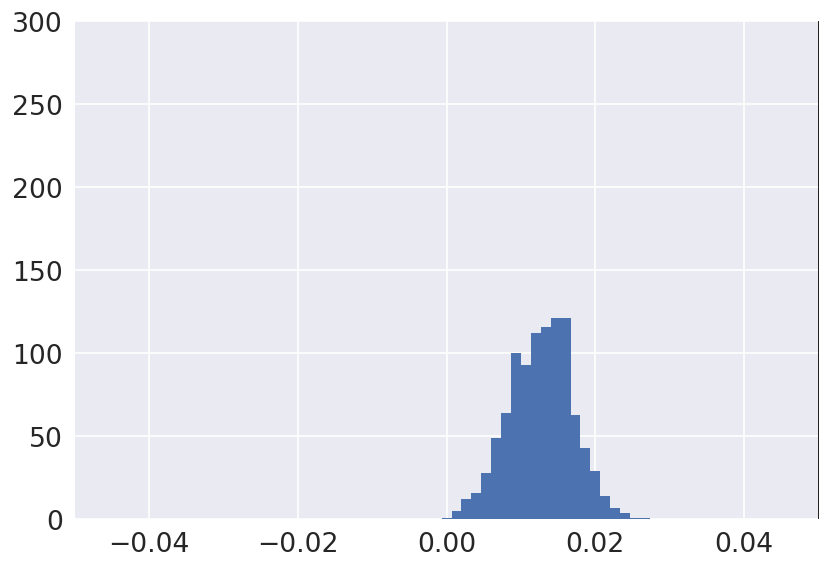

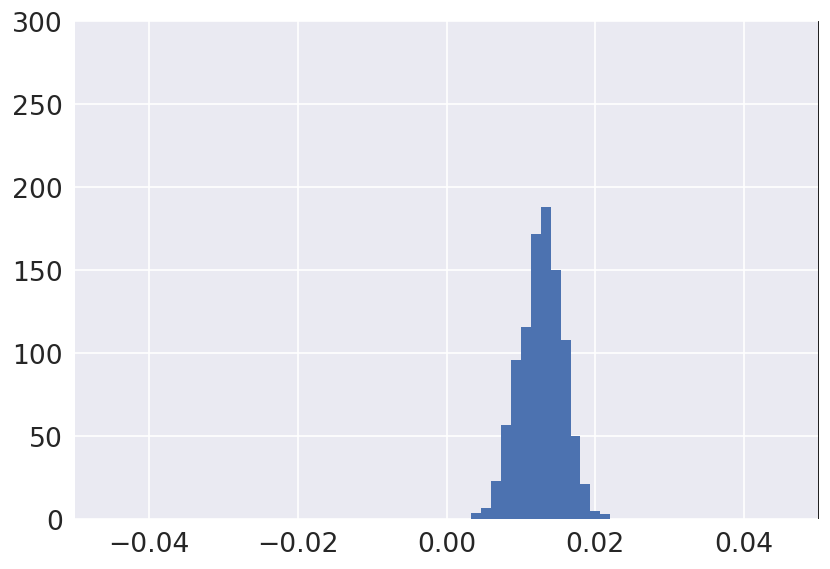

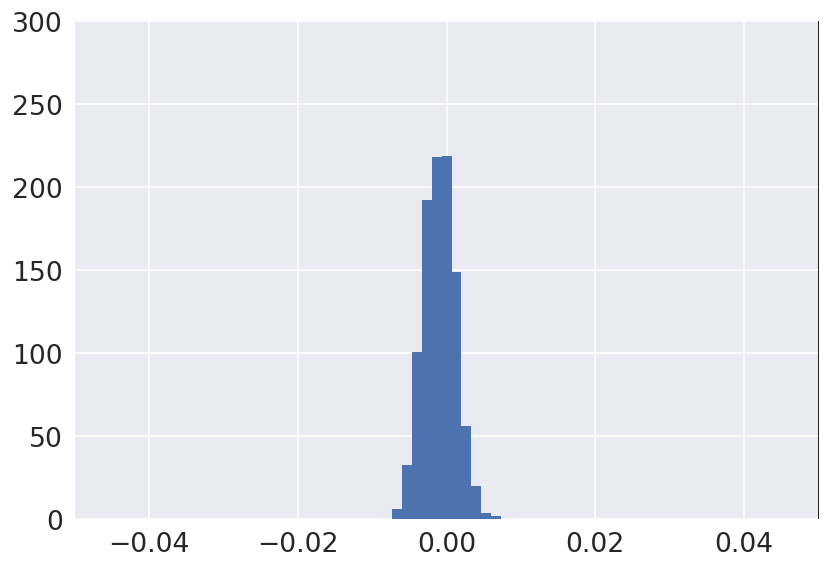

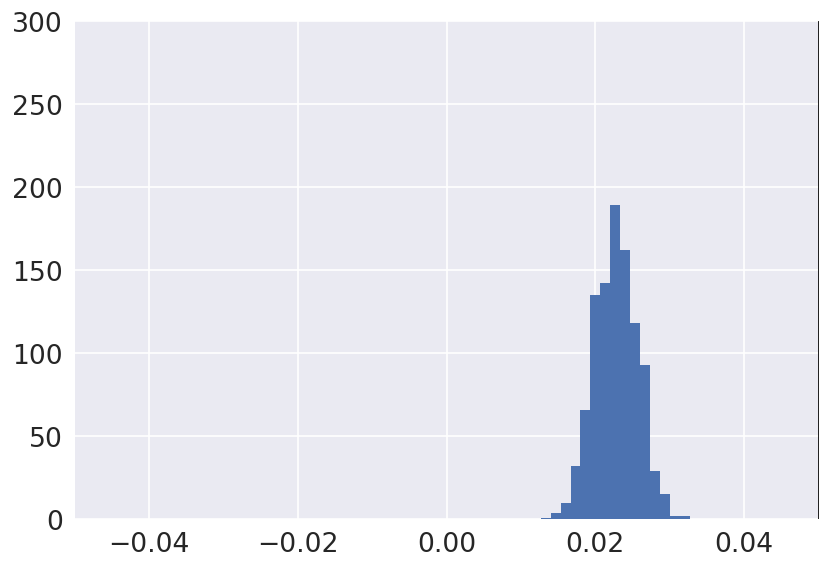

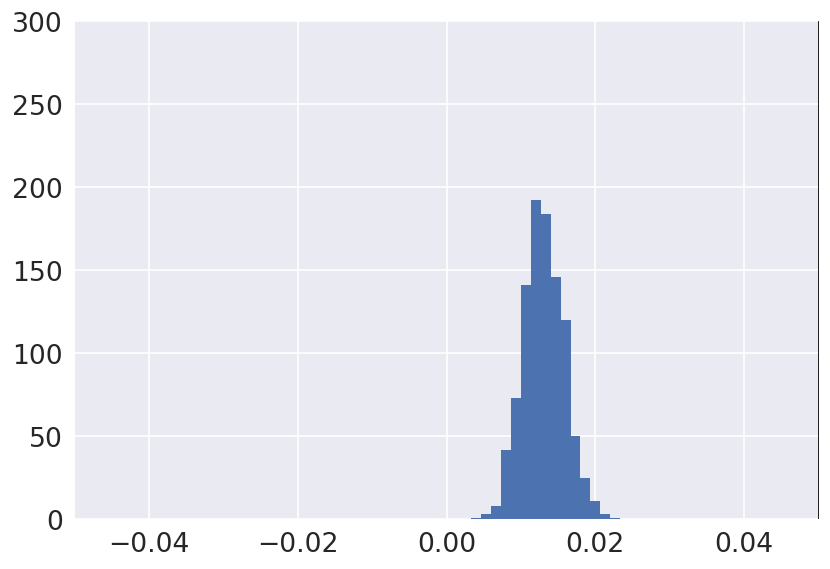

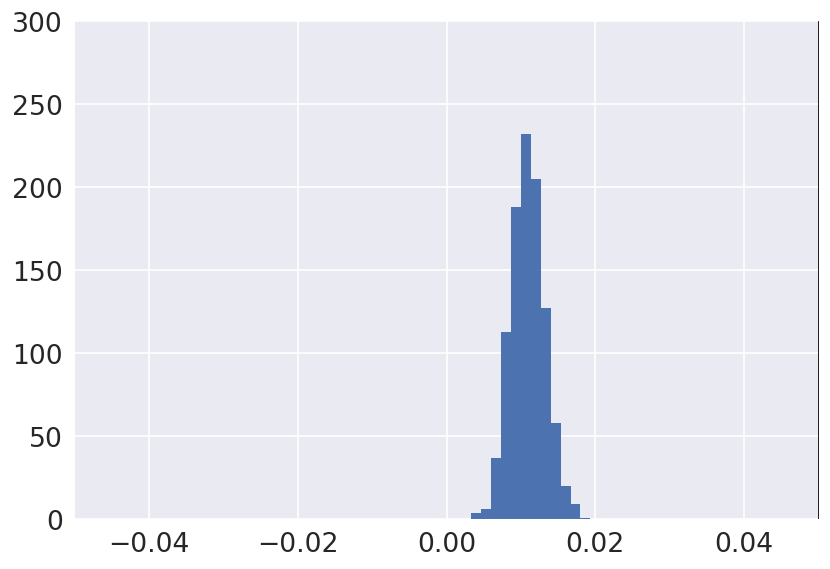

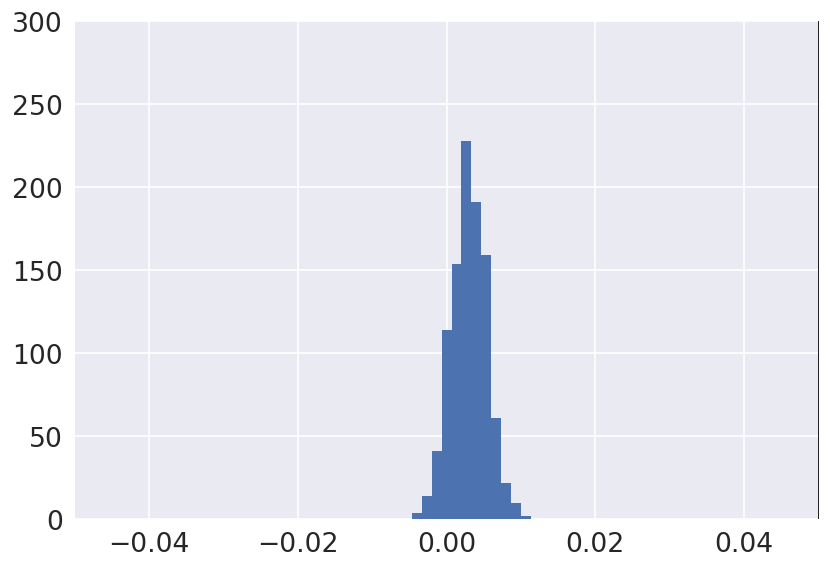

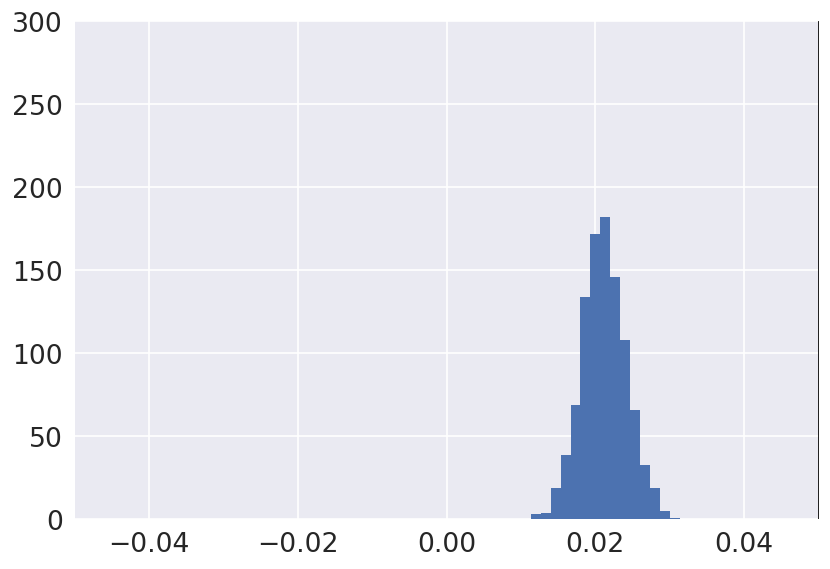

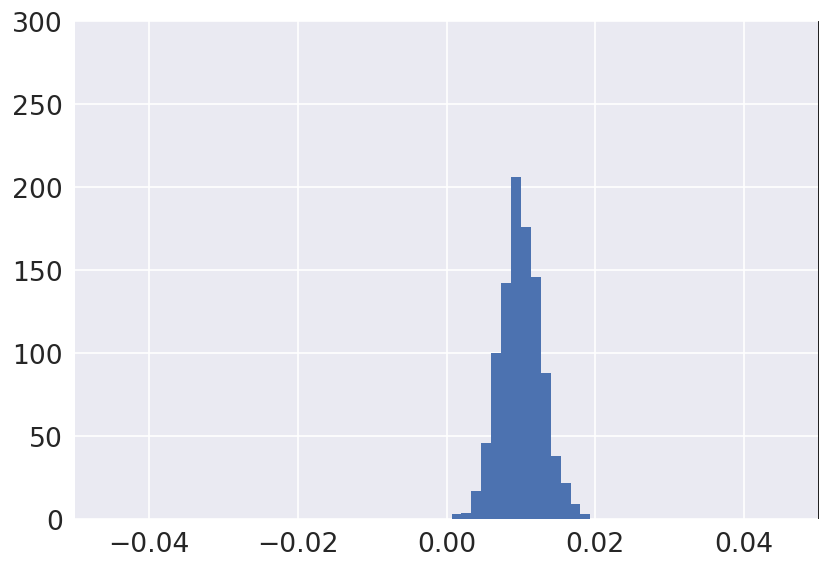

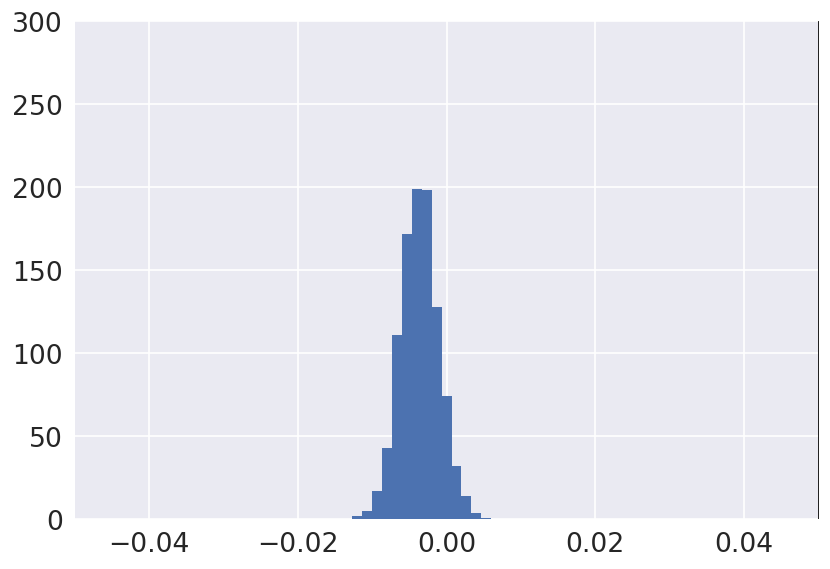

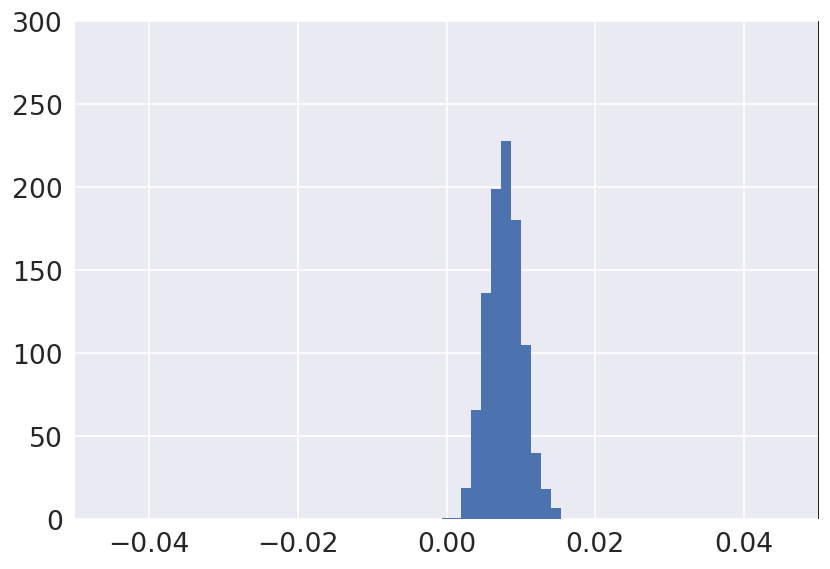

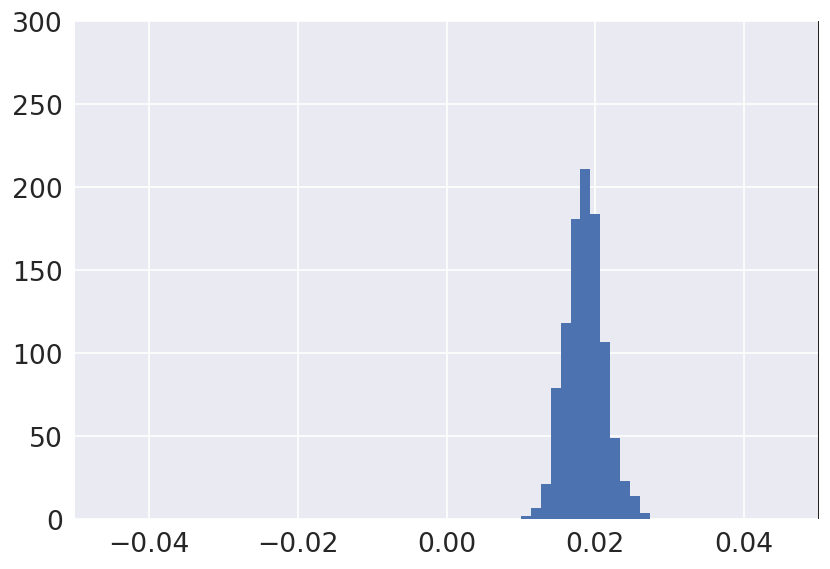

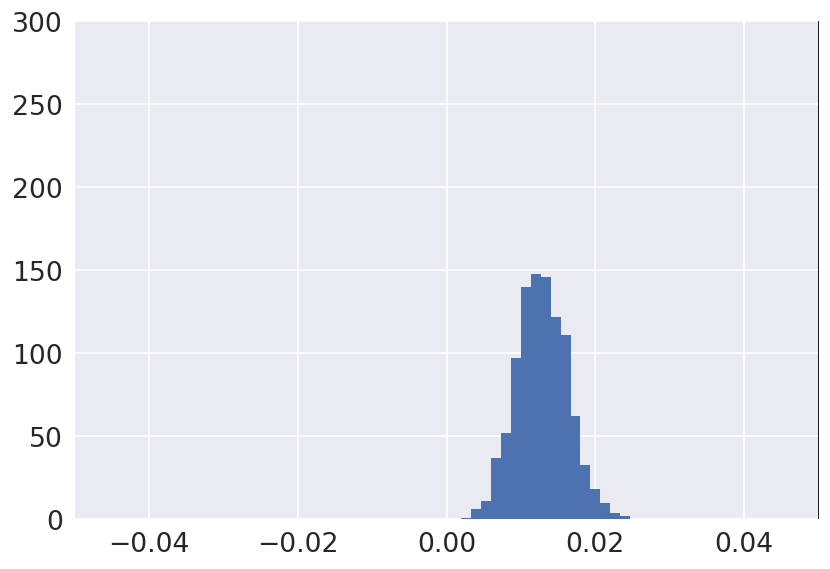

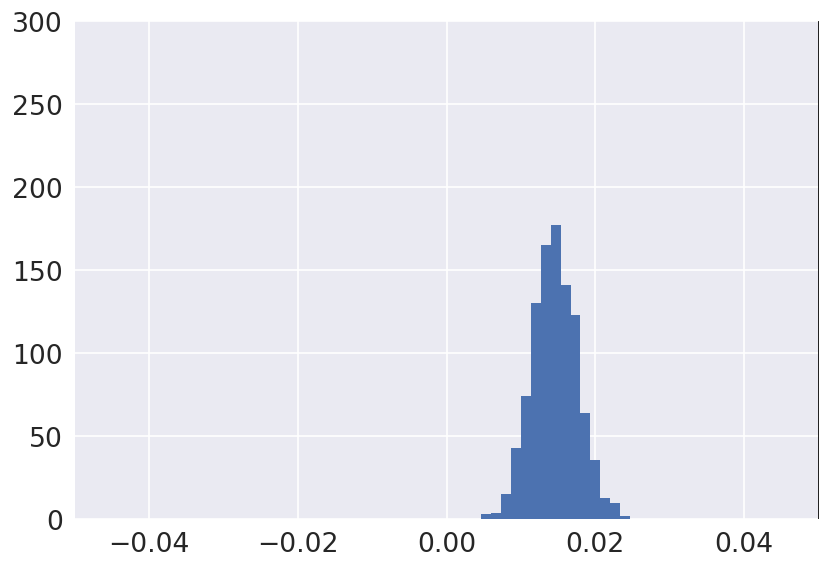

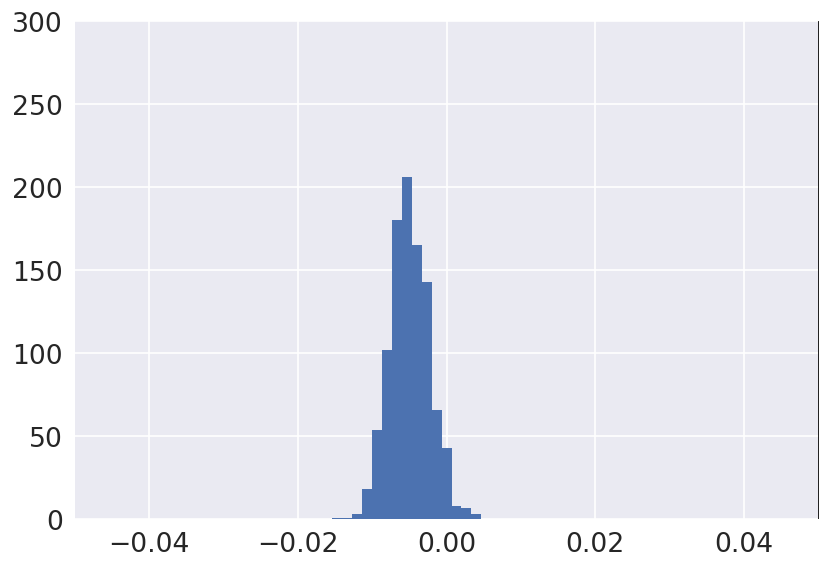

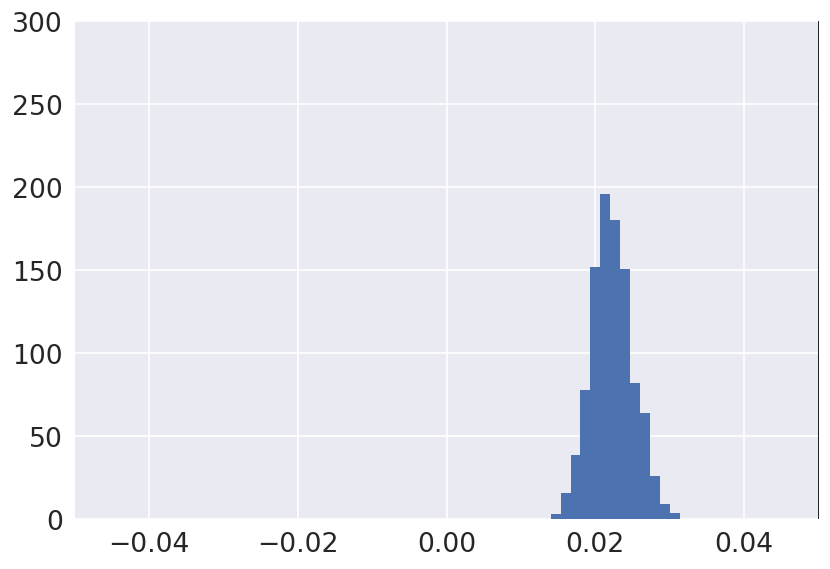

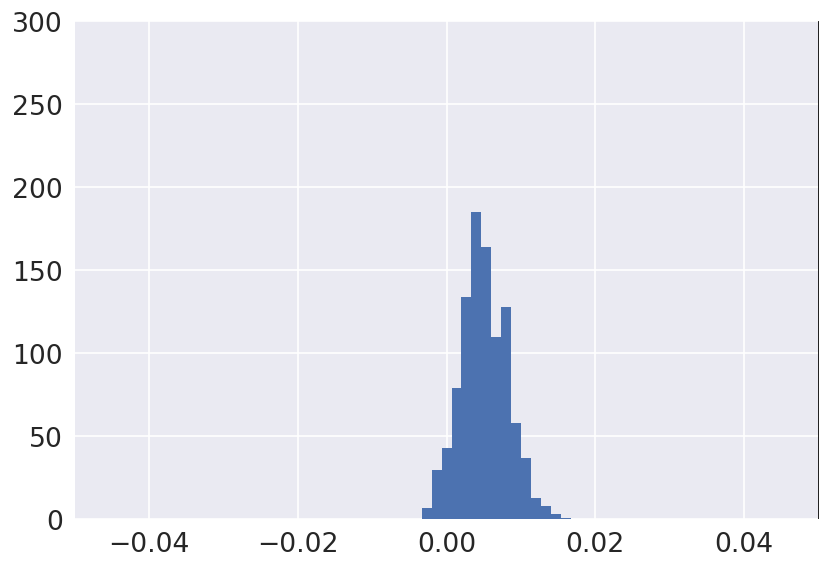

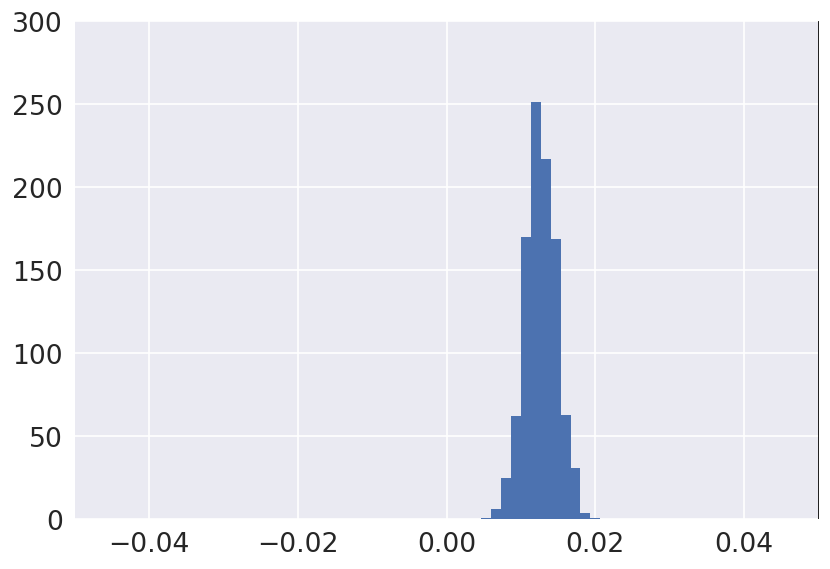

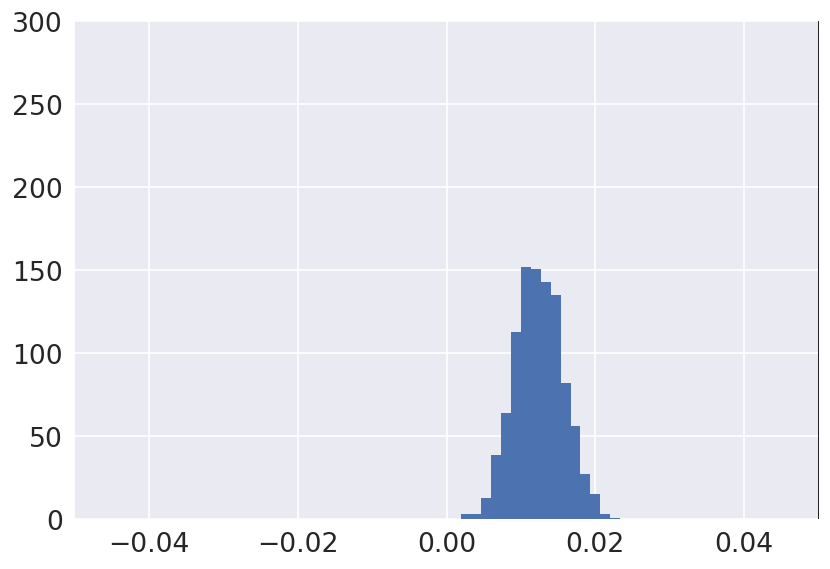

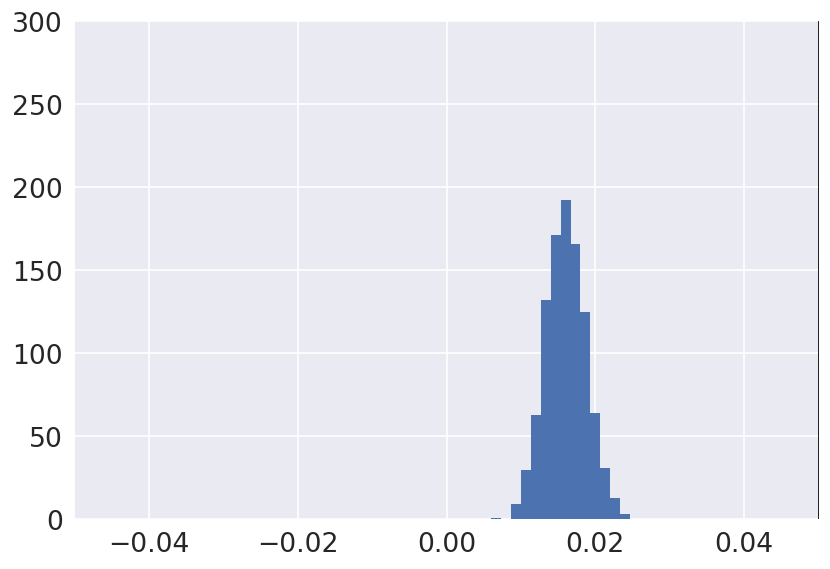

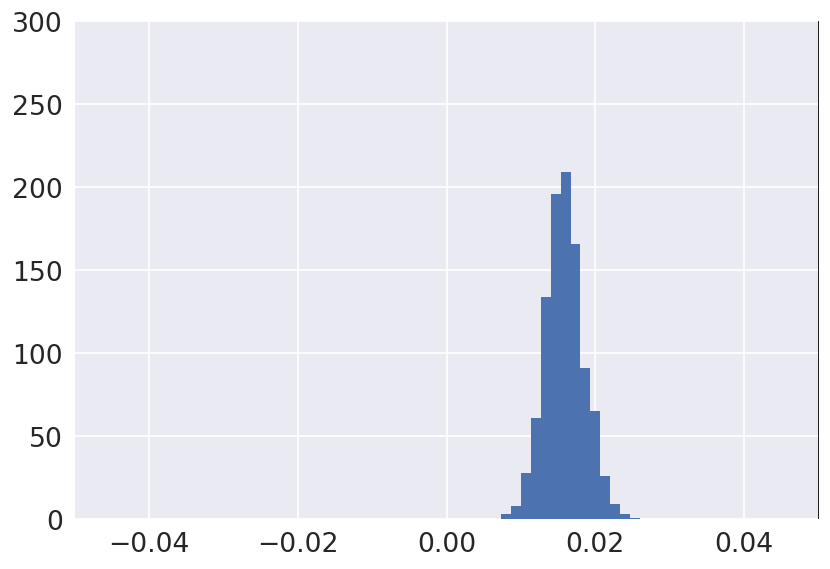

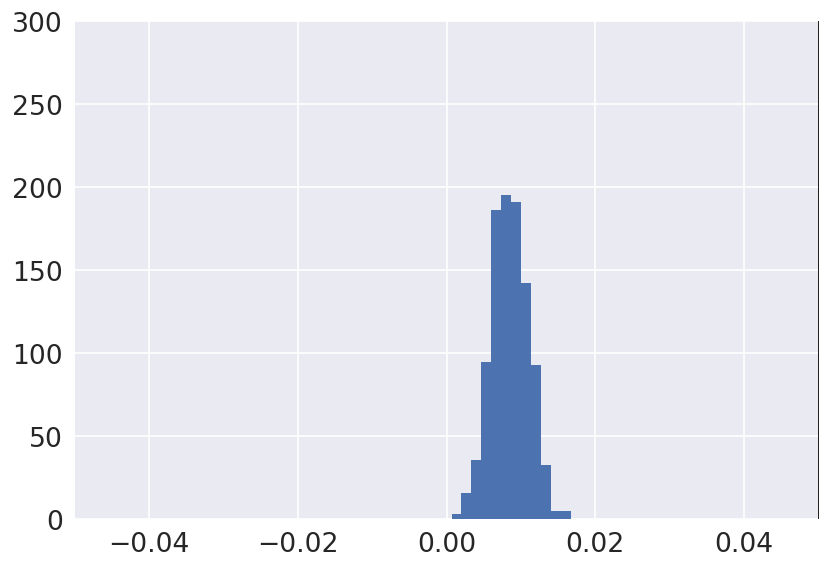

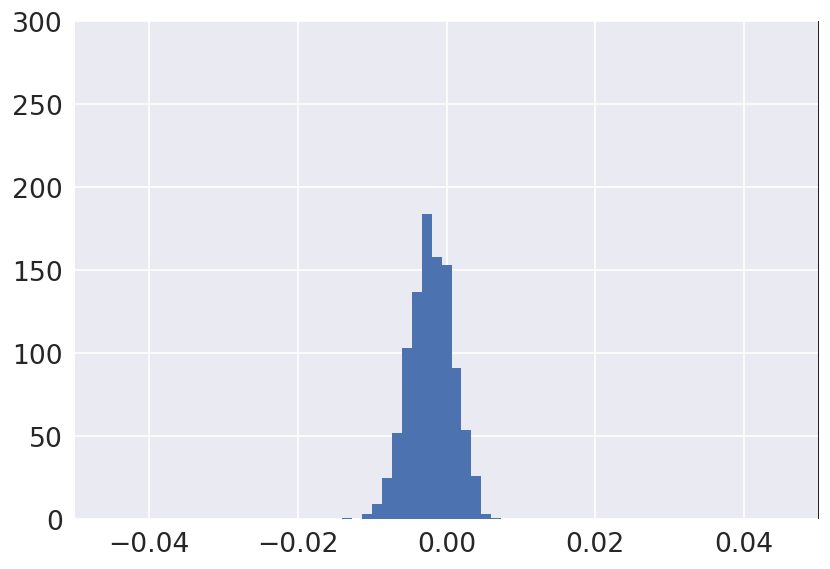

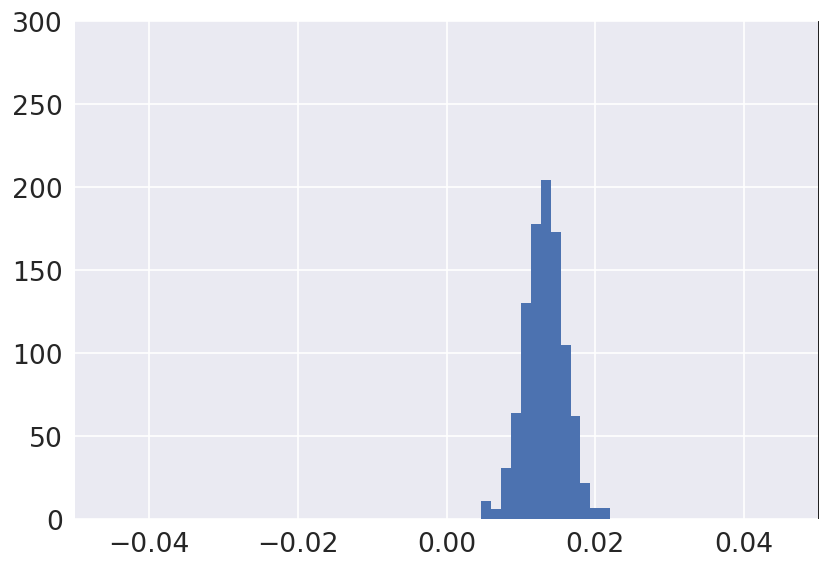

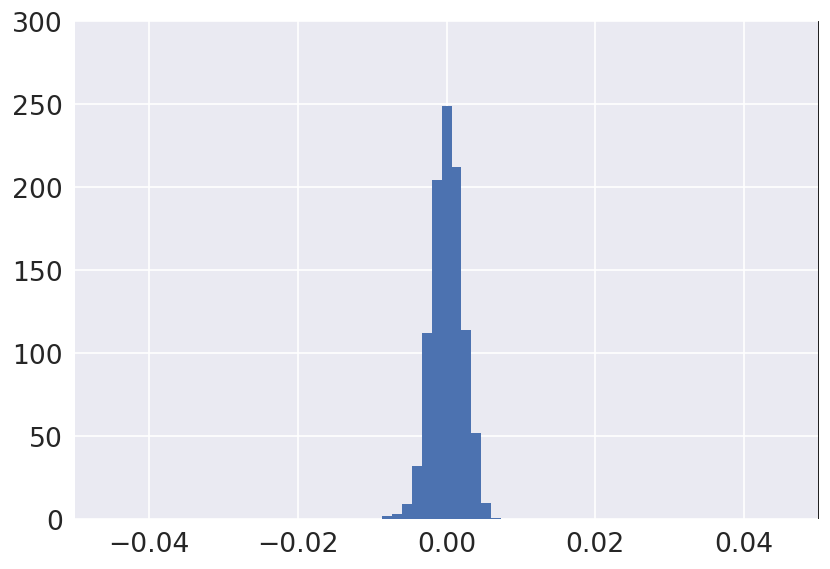

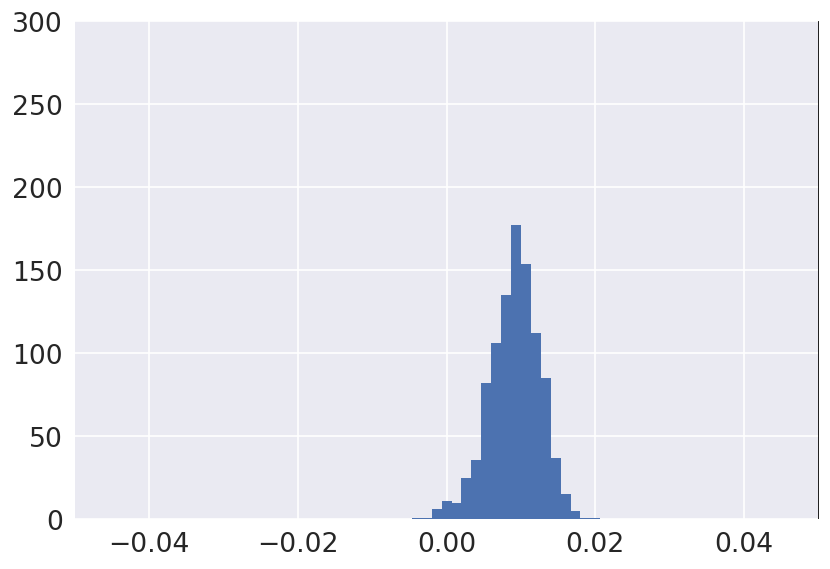

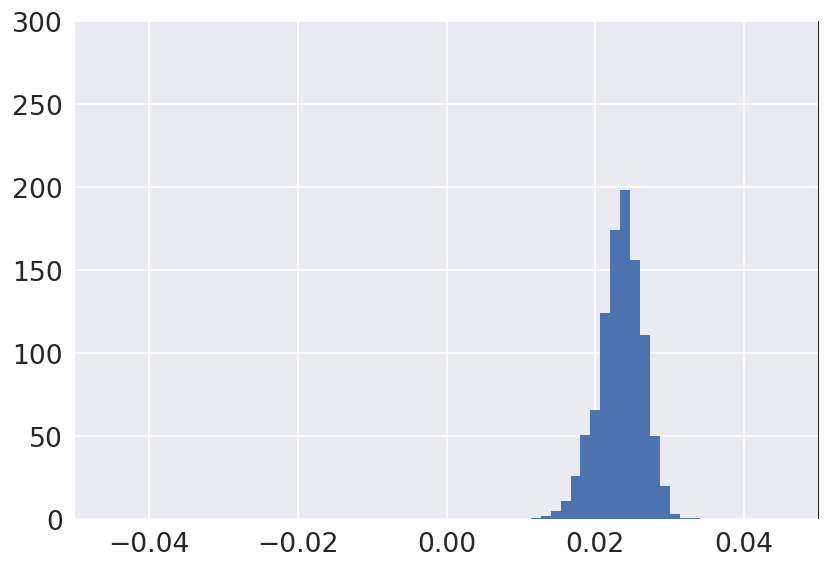

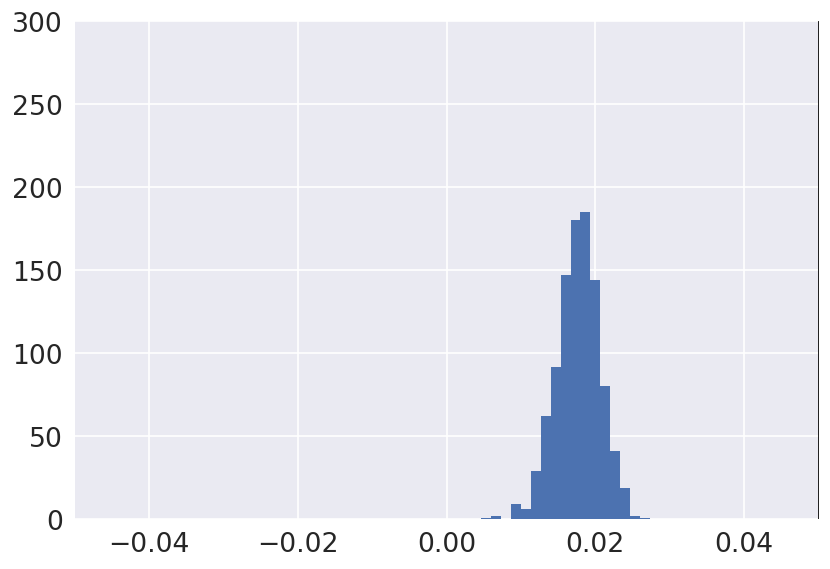

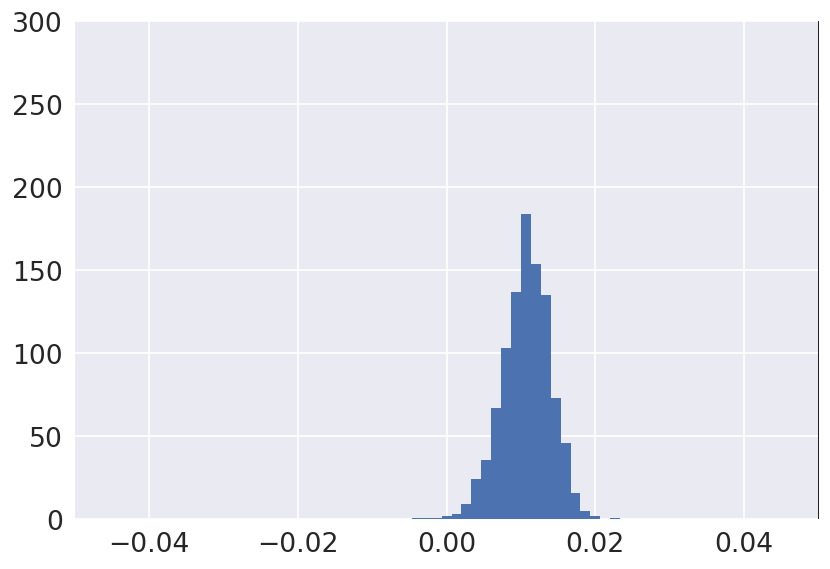

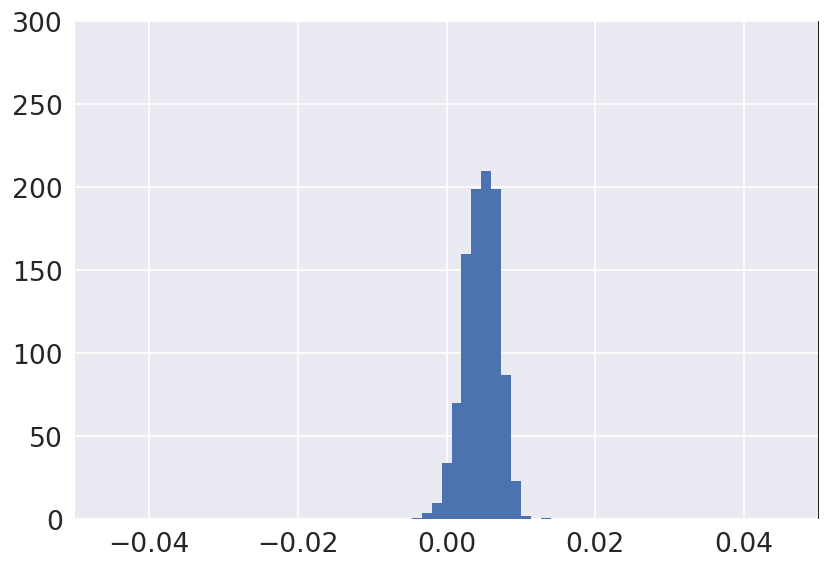

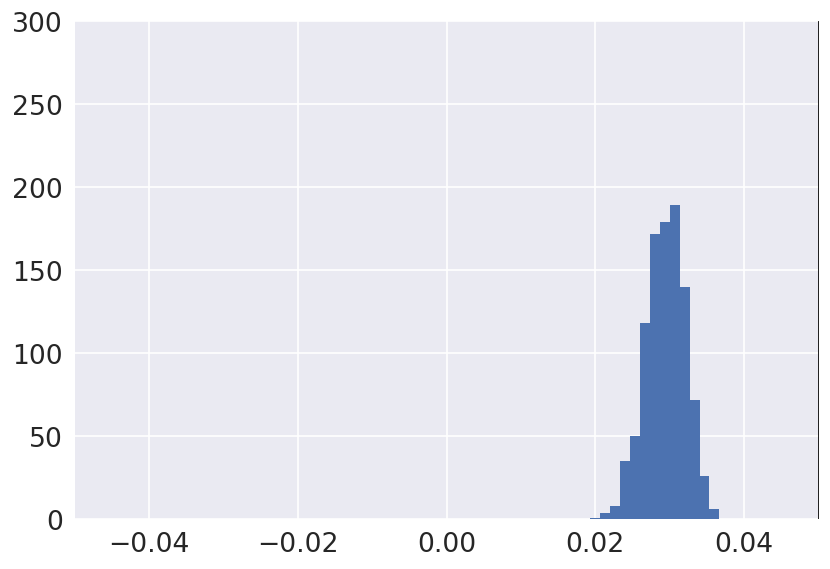

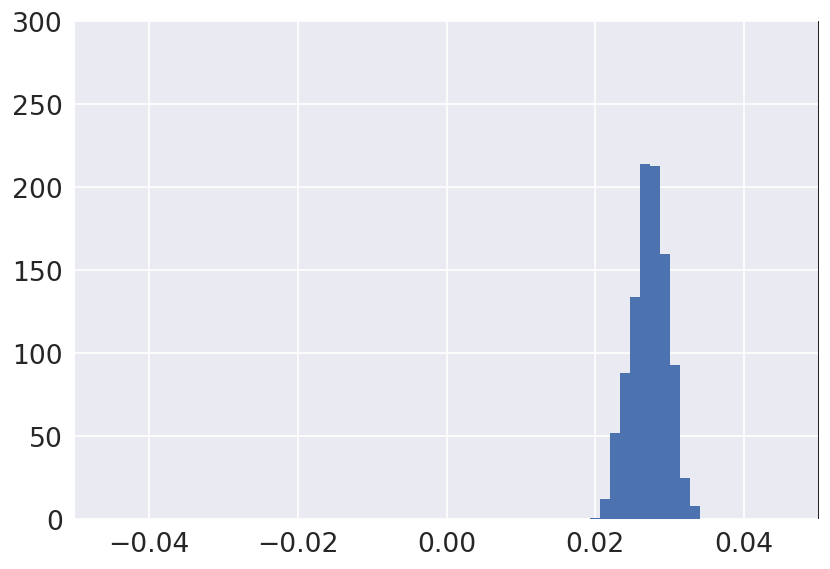

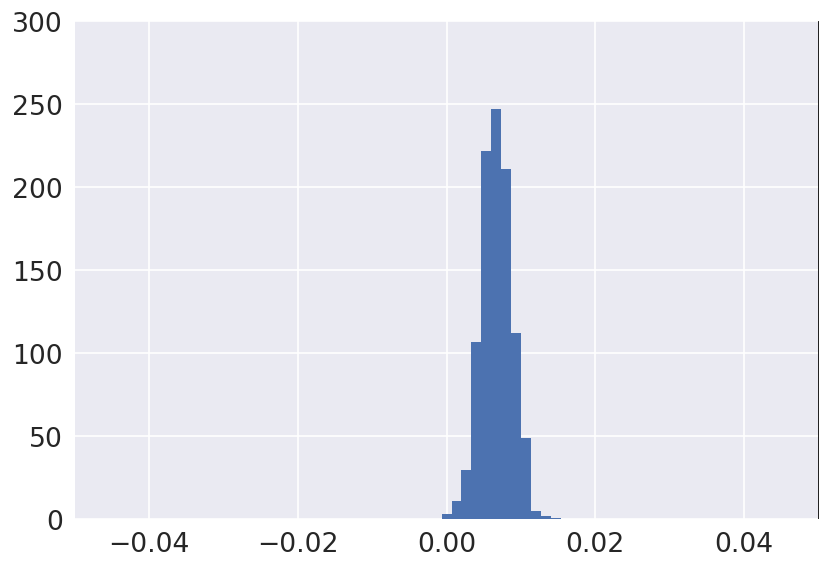

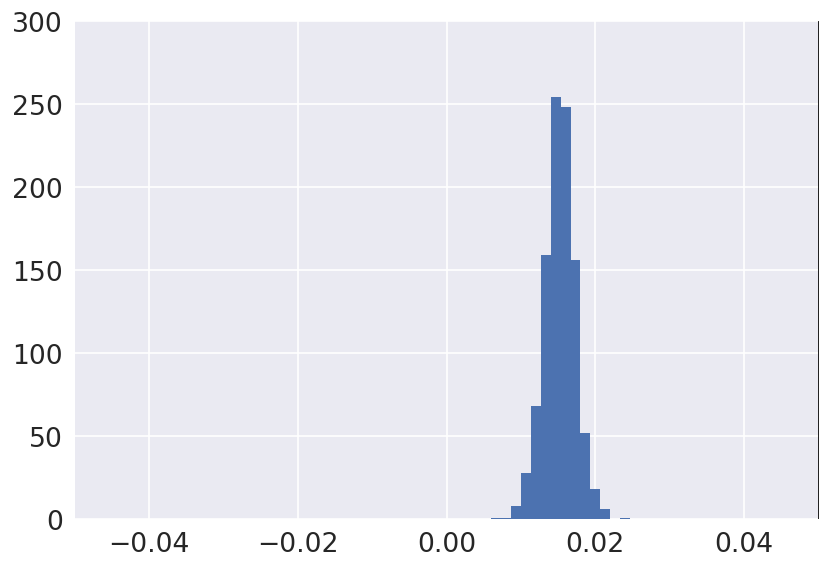

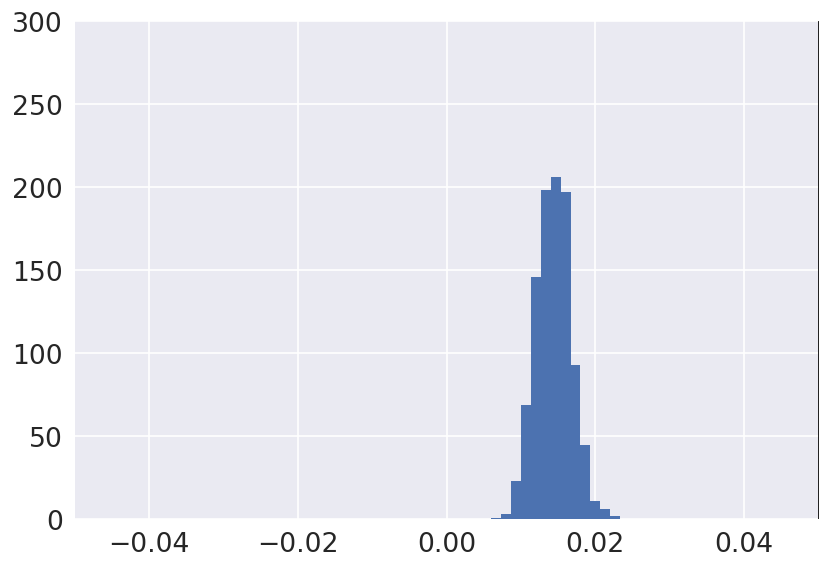

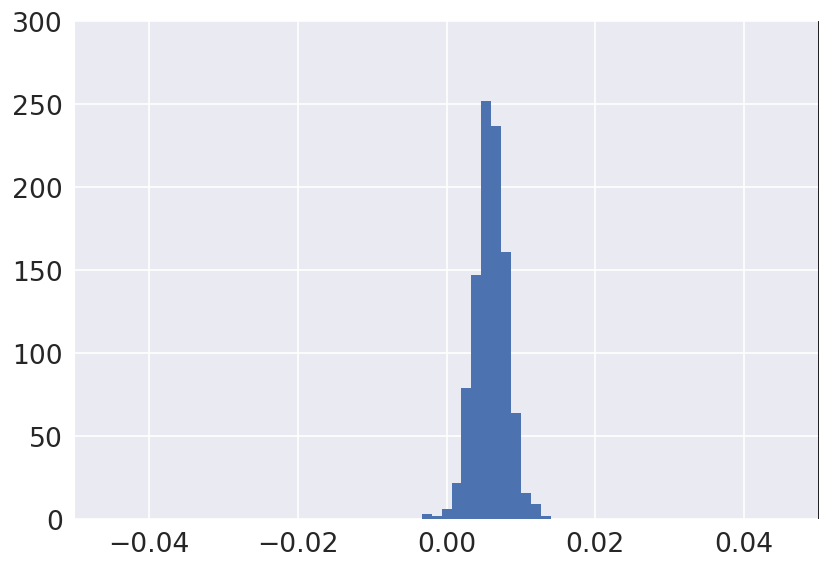

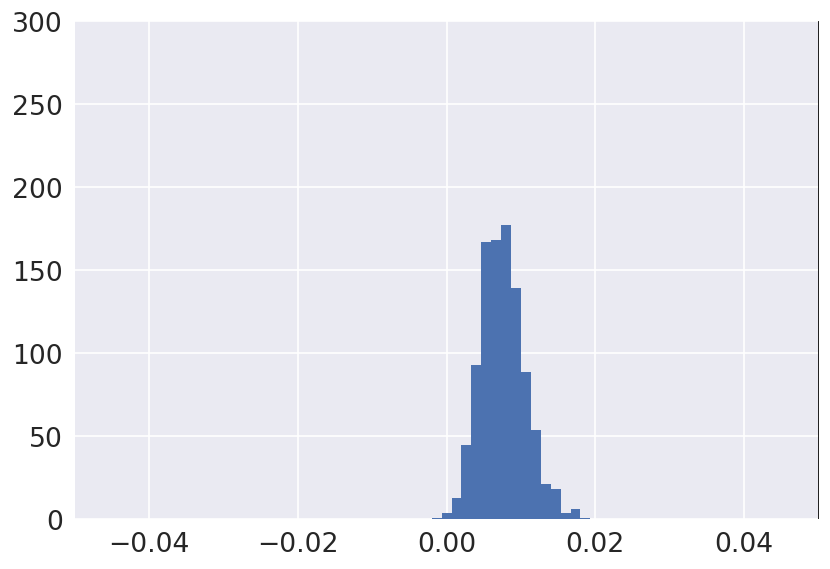

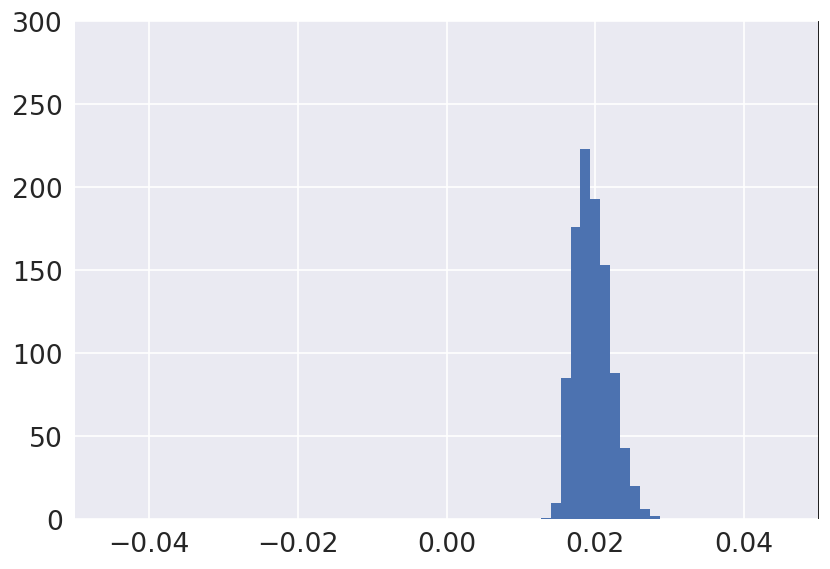

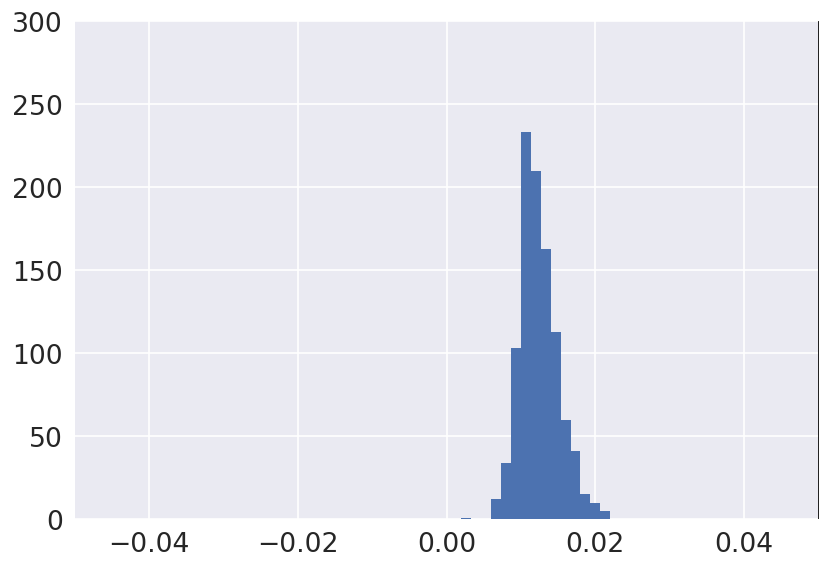

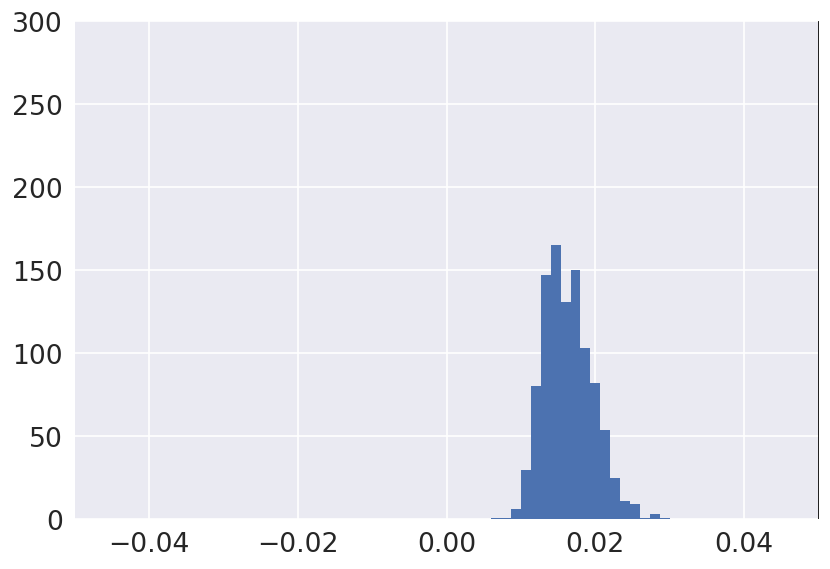

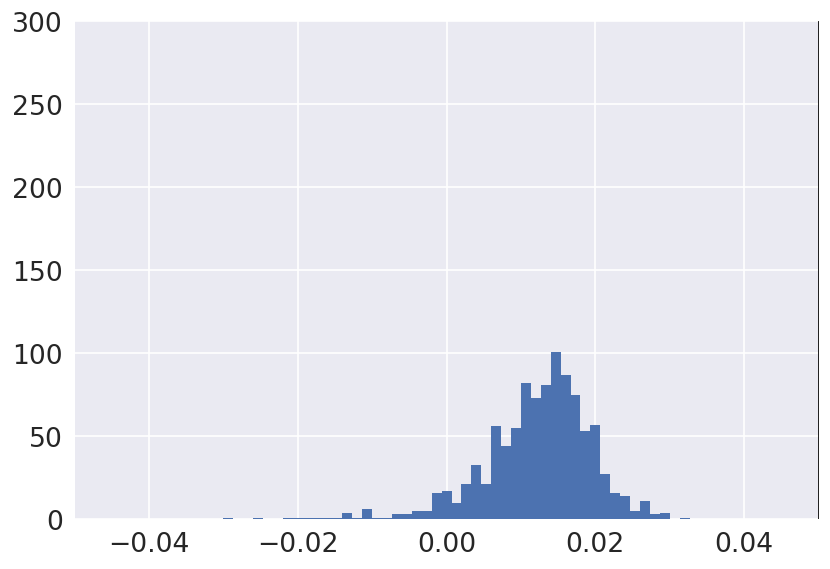

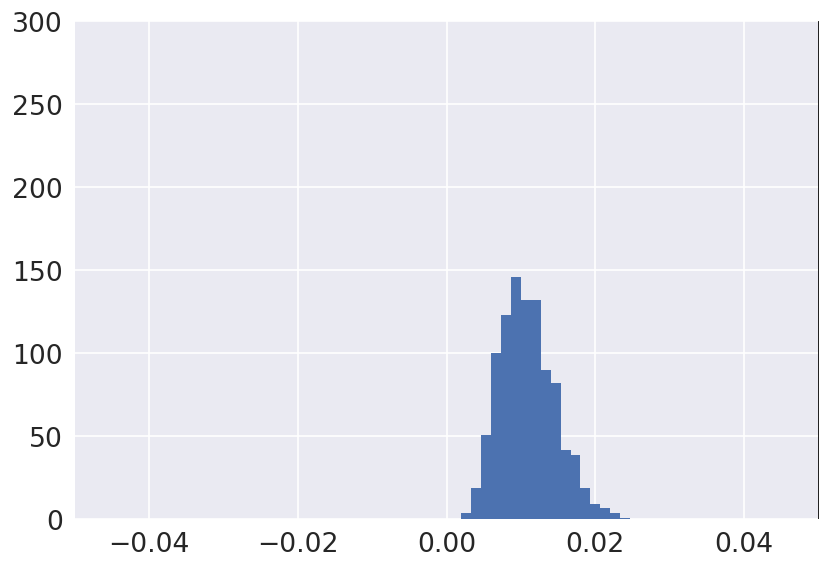

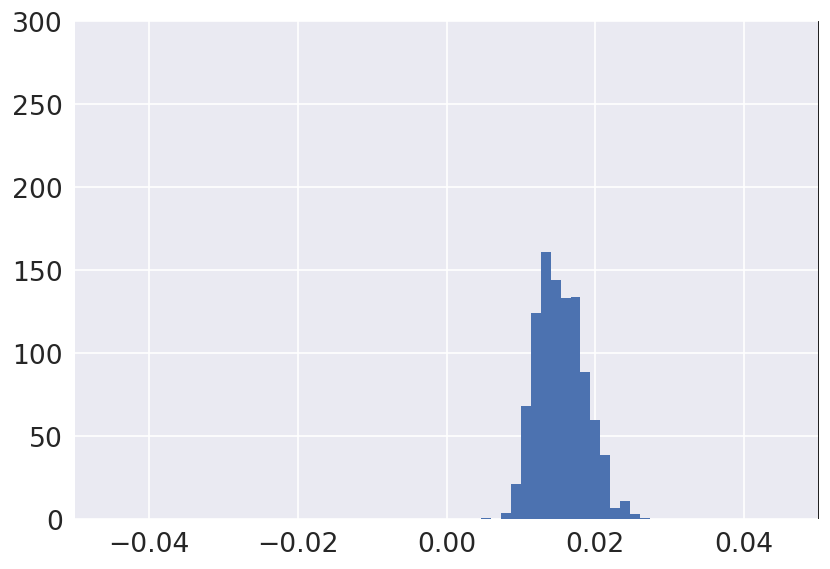

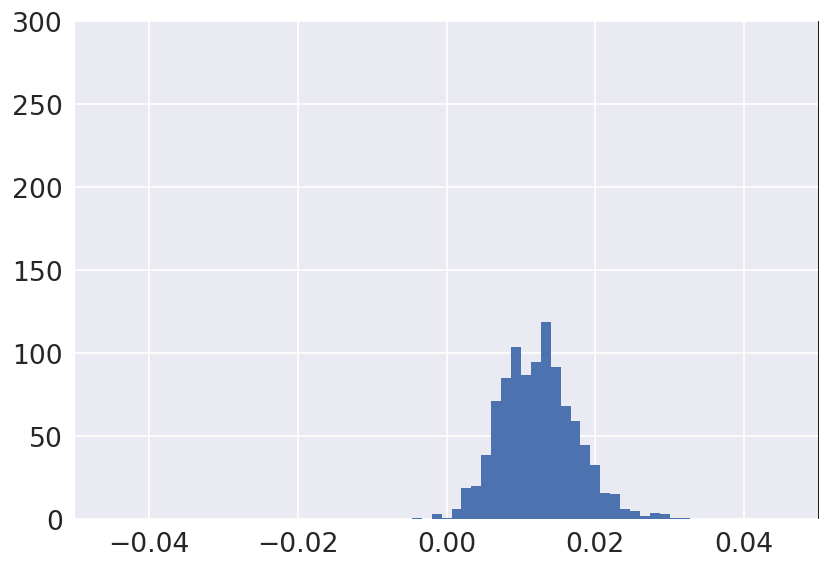

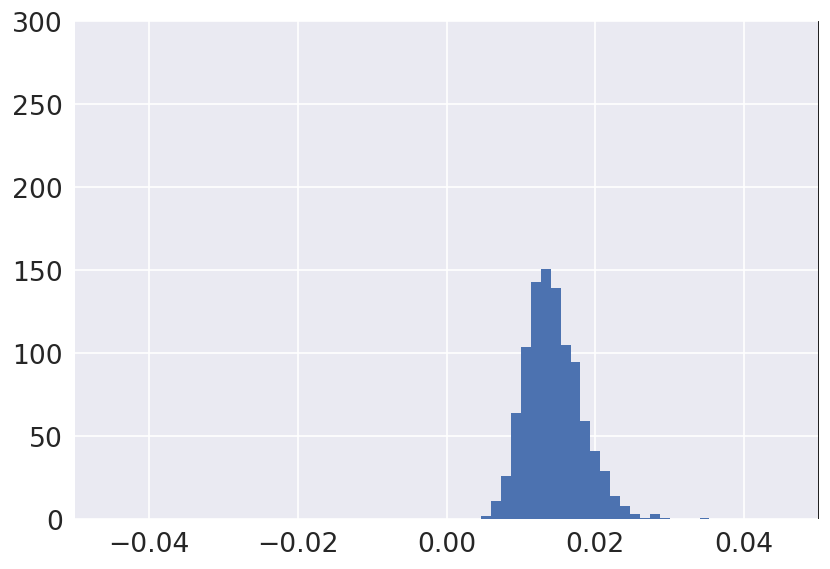

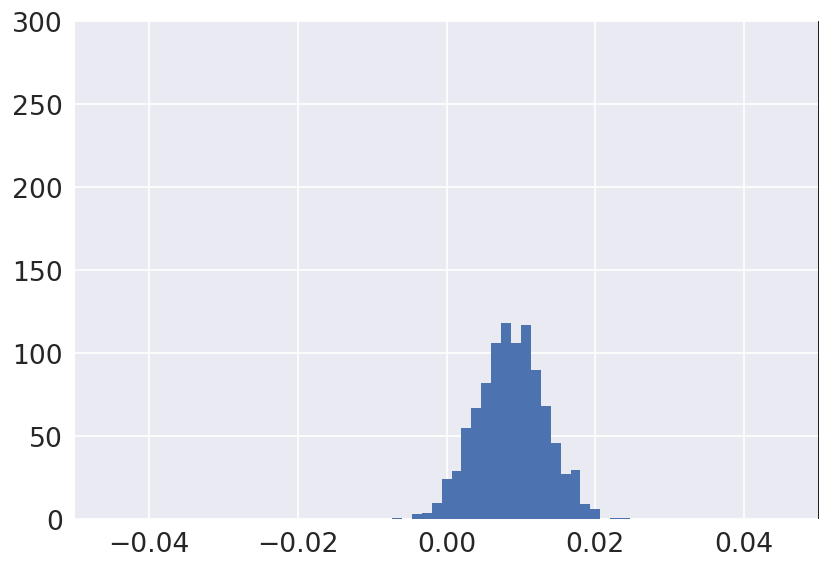

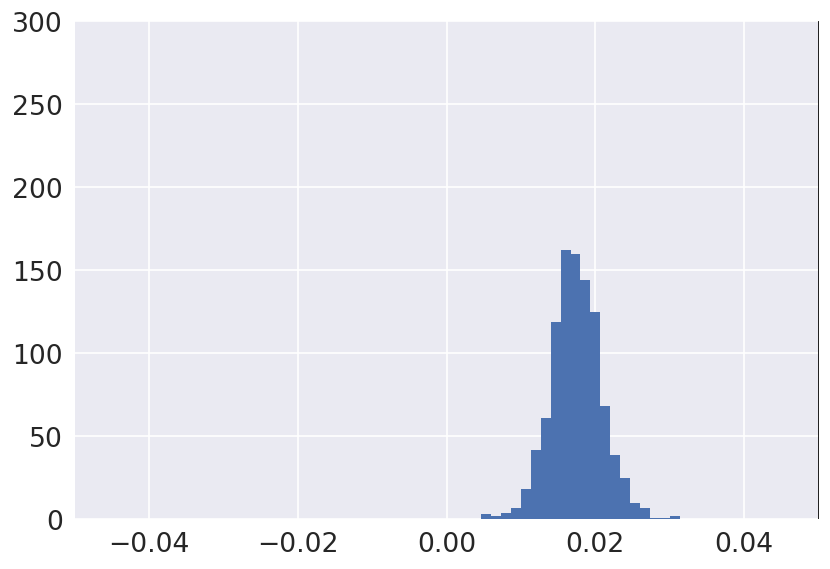

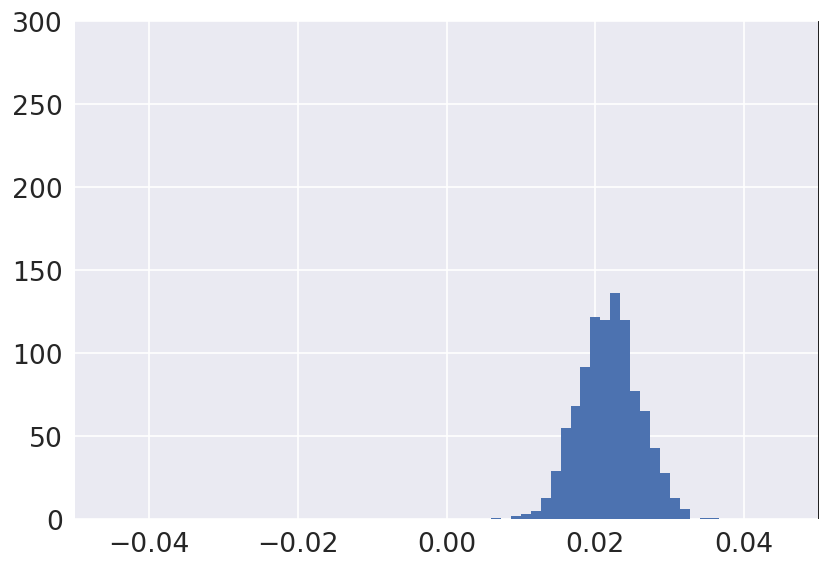

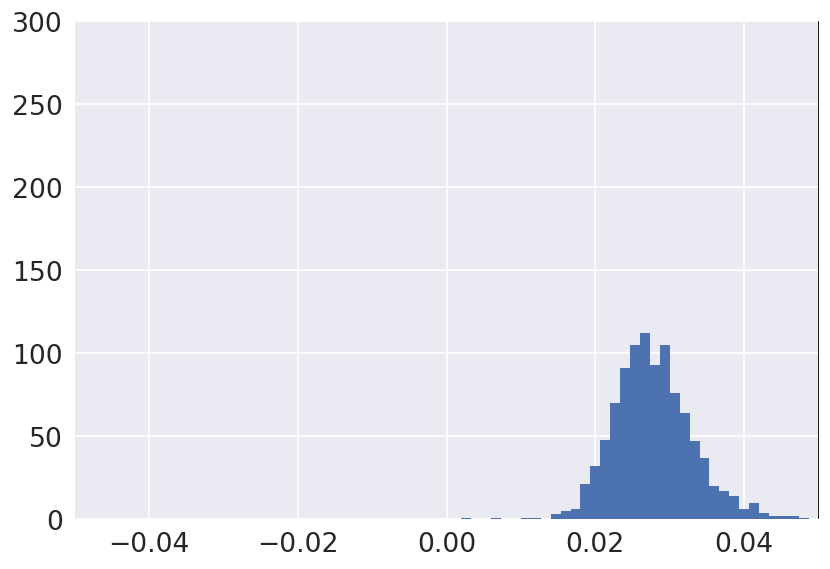

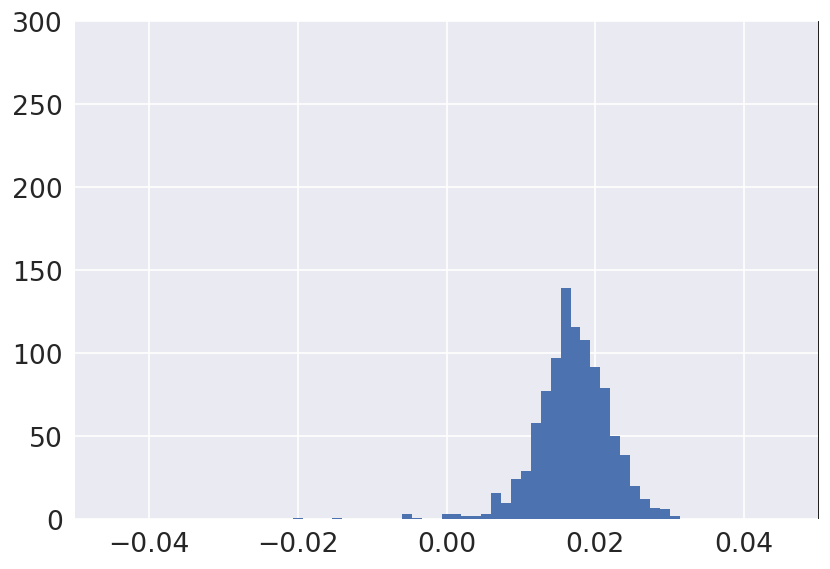

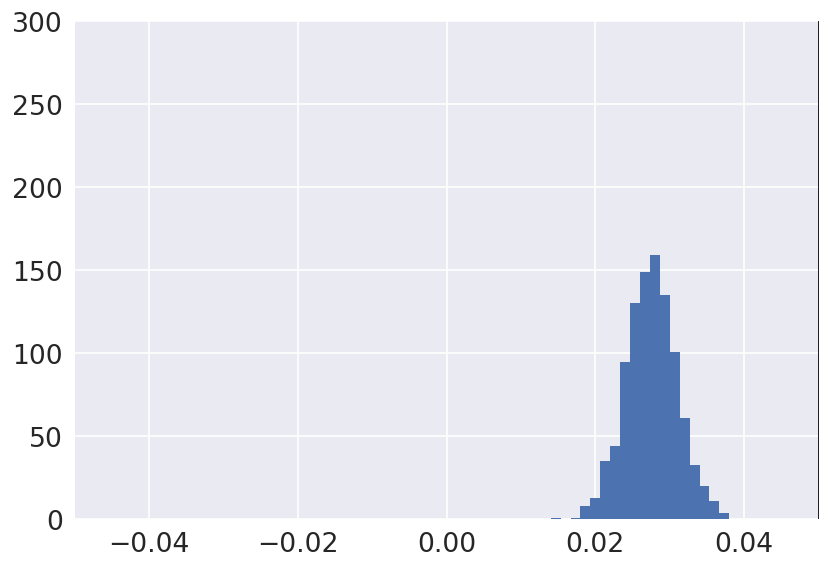

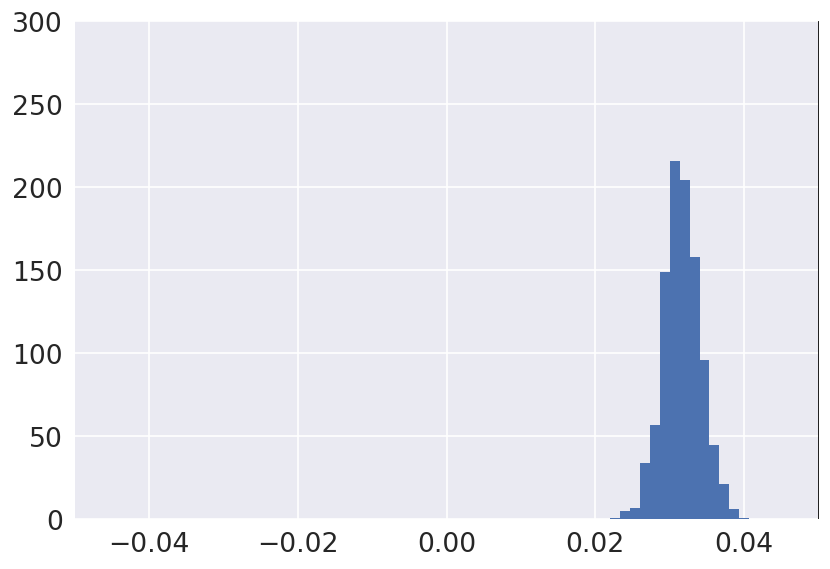

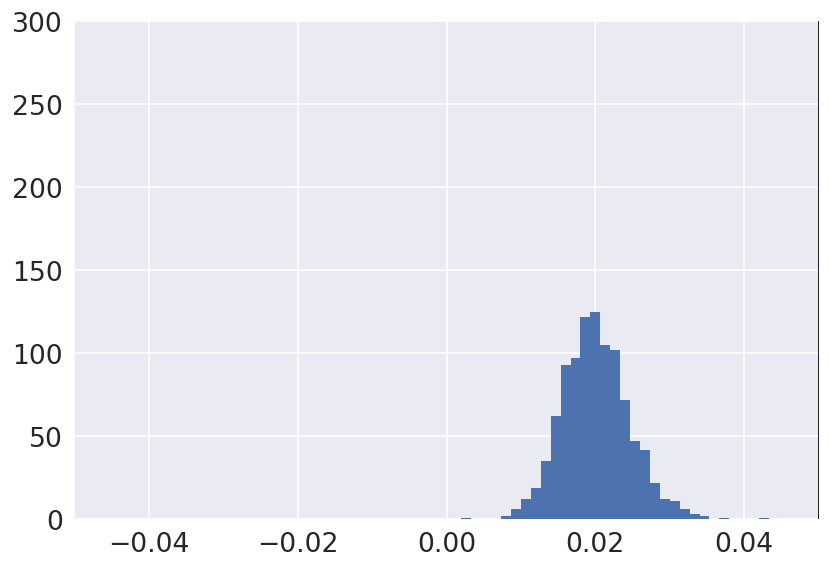

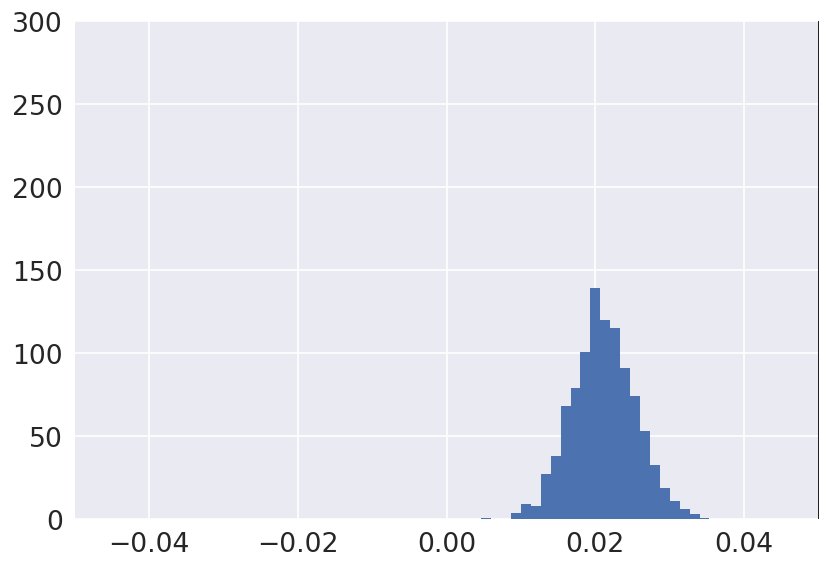

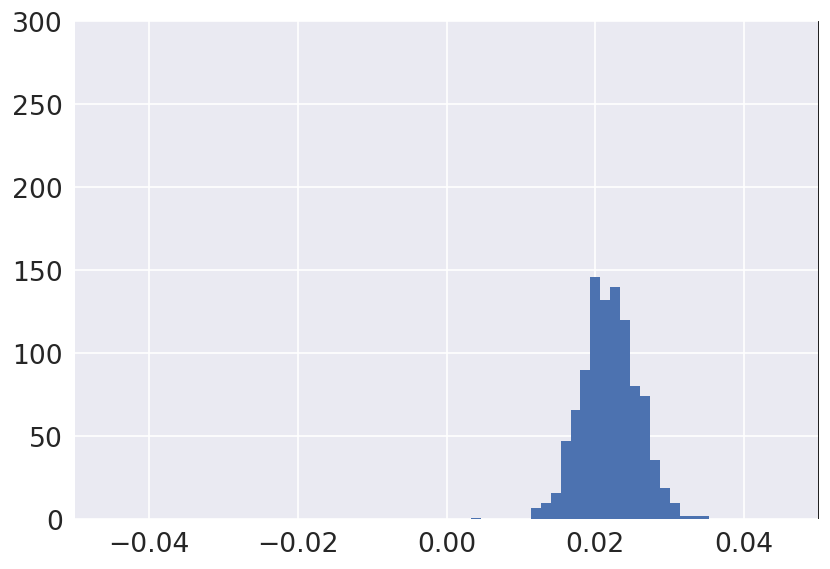

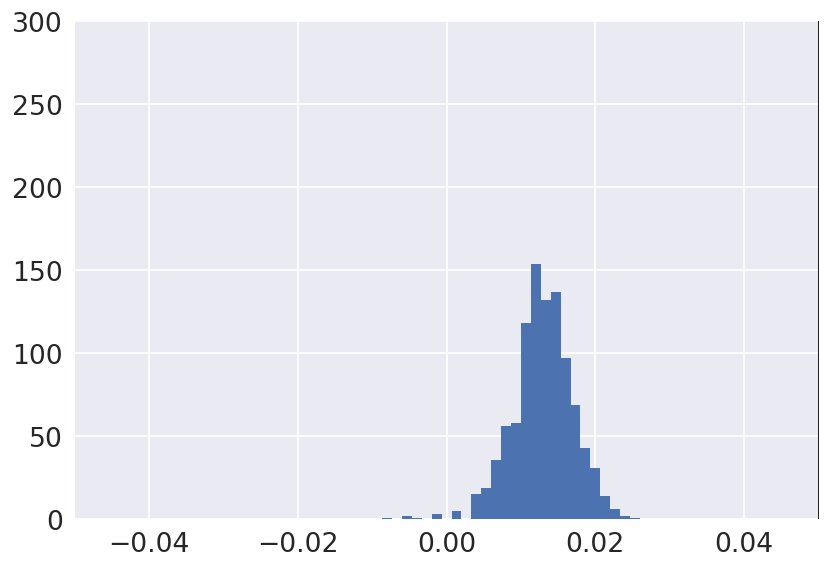

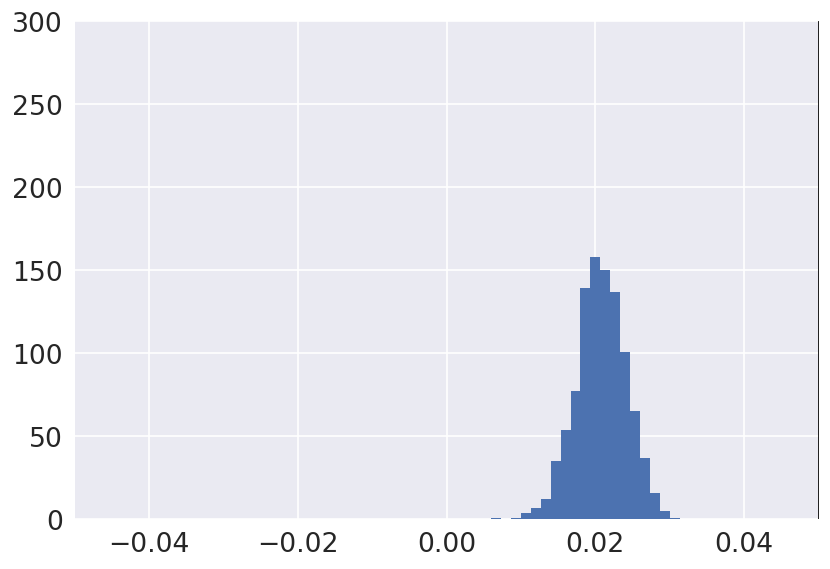

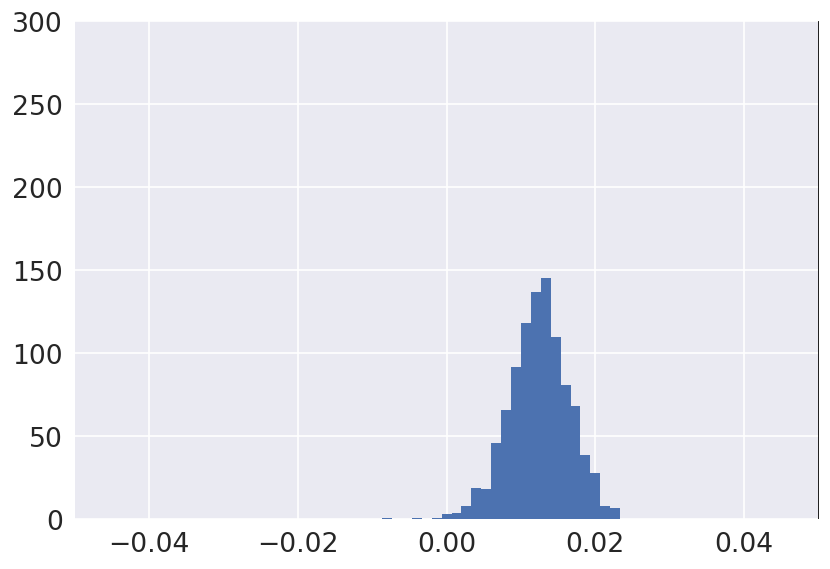

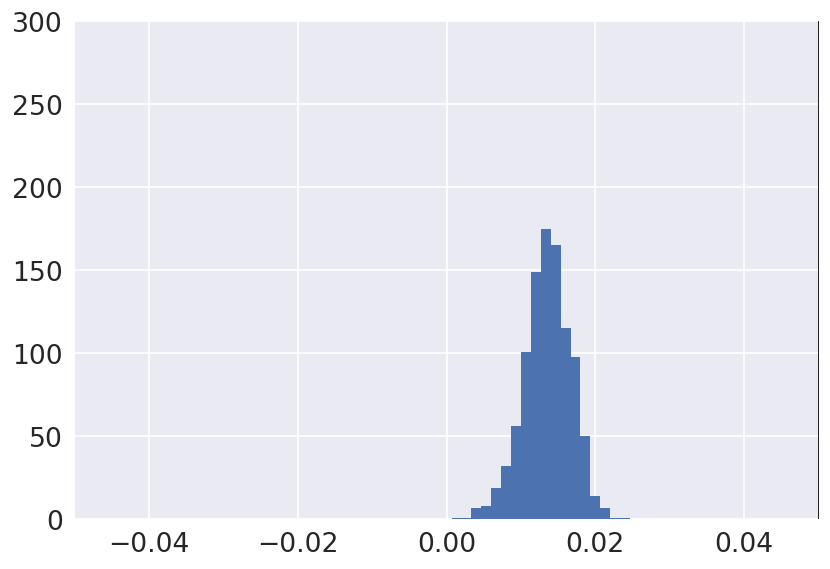

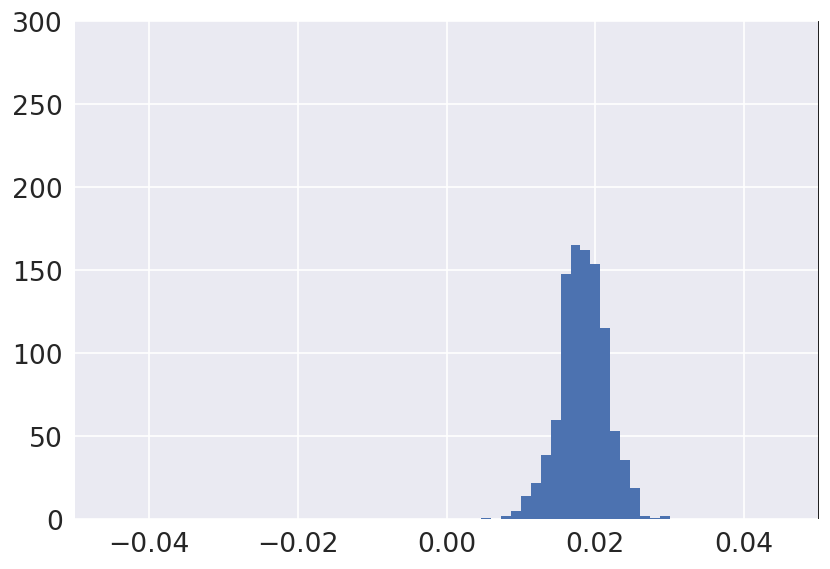

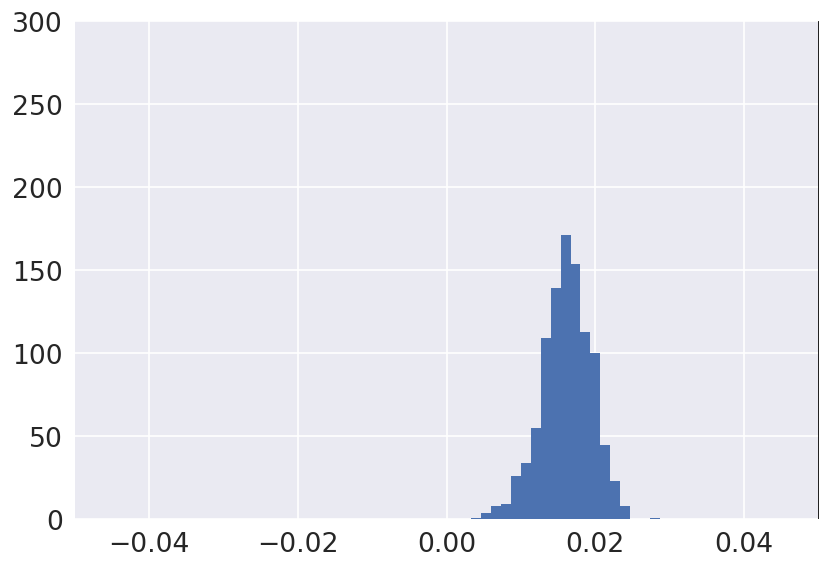

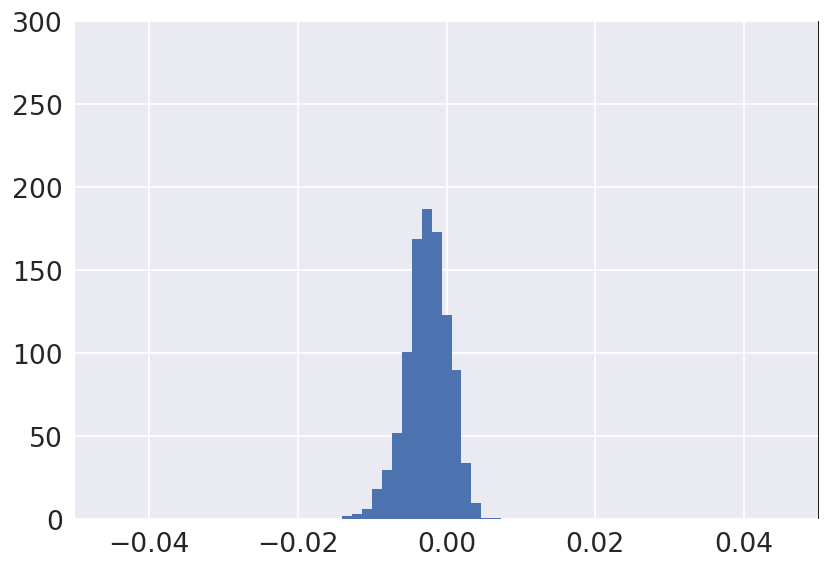

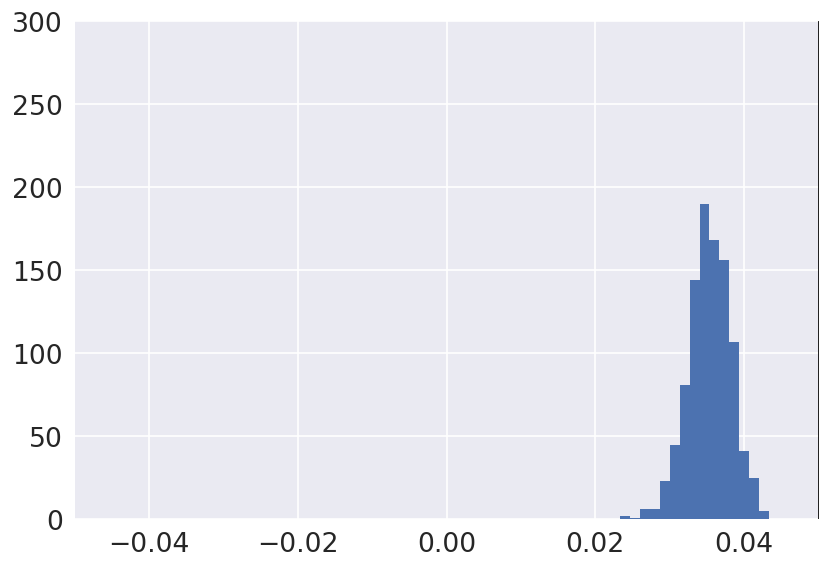

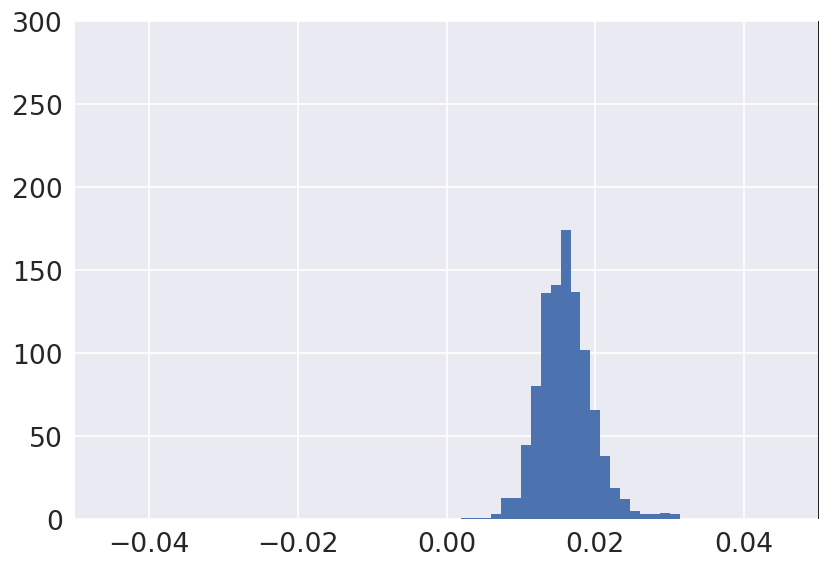

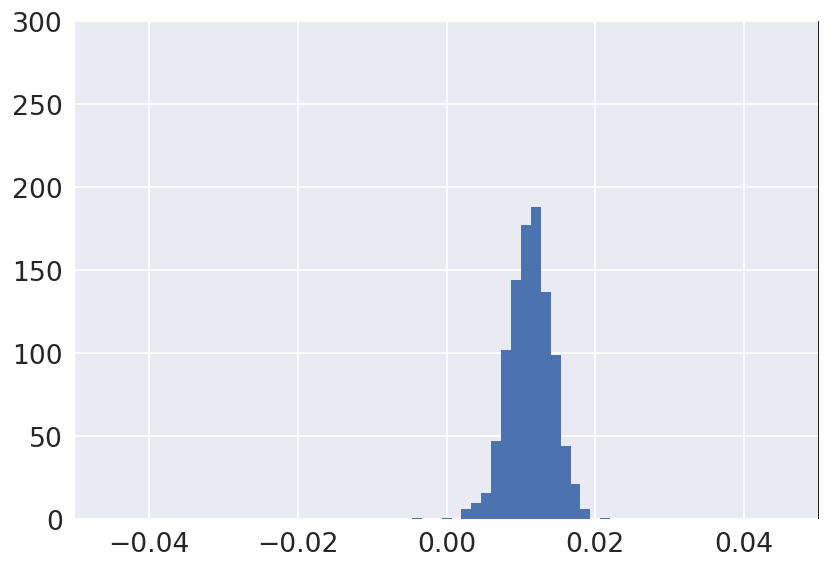

In [8]:
for prediction_elu in covnet_mo_elu_predictions:
    predictions_hist(np.reshape(prediction_elu[4], len(prediction_elu[3])), test_set_model_params().jumps_mu, 
                 "Convolutional Architecture - Multiple Output - ELU", 
                 "Jumps Mu",
                 min_edge = -0.05,
                 max_edge = 0.05,
                 y_lim = (0, 300),
                 save_to_file = False);

### Convolutional Architecture: Single Output

#### Lambda

In [9]:
histories_lambda = np.load("Lambda_histories.npy")
lambda_mape = []
lambda_mse = []
lambda_r2 = []

for history in histories_lambda:
    lambda_r2.append(history["r2"])
    lambda_mse.append(history["loss"])
    lambda_mape.append(history["mean_absolute_percentage_error"])
    
lambda_mape = np.reshape(lambda_mape, len(lambda_mape))
lambda_r2 = np.reshape(lambda_r2, len(lambda_r2))
lambda_mse = np.reshape(lambda_mse, len(lambda_mse))

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


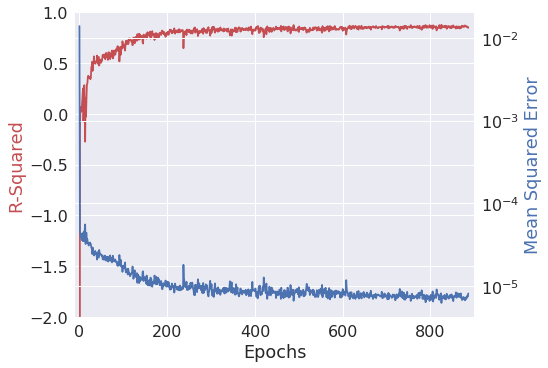

In [12]:
fig, ax1 = plt.subplots()
ax1.plot(lambda_r2, c='r')
ax1.set_xlabel('Epochs')
ax1.set_ylim(-2, 1)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('R-Squared', color='r')
ax1.tick_params('y', color='r')

ax2 = ax1.twinx()
ax2.plot(lambda_mse)
ax2.set_ylabel('Mean Squared Error', color='b')
ax2.set_yscale('log')
ax2.tick_params('y', color='b')
ax1.set_xlim(-10, 900)

fig.tight_layout()
plt.show()